### Import general functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from cycler import cycler
mpl.rcParams['text.usetex'] = False
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family']        = 'sans-serif'
mpl.rcParams['font.sans-serif']    = ['Arial', 'Helvetica Neue', 'DejaVu Sans']
plt.style.use('seaborn-v0_8-colorblind')

import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from statsmodels.stats.multitest import multipletests
import scipy

from analysis_helper_funcs import load_pickle, compute_noise_ceiling, compute_gpn_correlations, compute_network_correlations, mean_and_bootstrap_ci, variance_partitioning_analysis, friedman_wilcoxon_2x2, build_2x2xK_df_from_best, friedman_wilcoxon_2x2xK

### GPN/GSN name - path mapping

In [2]:
gpn_names = {
    'GPN-B-ILSVRC': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_0_bbv1_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-S-ILSVRC': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv1_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-ILSVRC': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv1_gaze_dg3_indp_0.25_rnndp_0.25_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-RS-ILSVRC': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv1_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-B-Dinov2_B': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_0_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-S-Dinov2_B': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-Dinov2_B': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-RS-Dinov2_B': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-B-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_0_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-S-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3_indp_0.25_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-RS-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-SimCLR-DG3p': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3p_indp_0.25_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-SimCLR-DG3r': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3r_indp_0.25_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-R-SimCLR-random': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_random_indp_0.25_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'cGSN-R-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3_indp_0.5_rnndp_0.25_gcpc_0_semc_0_scc_1_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'sGSN-R-SimCLR': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3_indp_0.5_rnndp_0.5_gcpc_0_semc_1_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1',
    'GPN-RS-ILSVRC-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv1_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-S-ILSVRC-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv1_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-RS-SimCLR-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-R-SimCLR-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_0_bbv6_gaze_dg3_indp_0.25_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-S-SimCLR-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-RS-Dinov2_B-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
    'GPN-S-Dinov2_B-init': 'gpn_lstm_n_1024_tm_3_t_6_recurrence_0_loc_1_bbv5_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_epoch_-1',
}

# GPN color scheme - colorblind friendly, from colorbrewer
color_coding = {
    'GPN-B-ILSVRC':  '#80cdc1',
    'GPN-S-ILSVRC':  '#018571',
    'GPN-R-ILSVRC':  '#dfc27d',
    'GPN-RS-ILSVRC': '#a6611a',
    'GPN-B-Dinov2_B':  '#80cdc1',
    'GPN-S-Dinov2_B':  '#018571',
    'GPN-R-Dinov2_B': '#dfc27d',
    'GPN-RS-Dinov2_B': '#a6611a',
    'GPN-B-SimCLR':  '#80cdc1',
    'GPN-S-SimCLR':  '#018571',
    'GPN-R-SimCLR': '#dfc27d',
    'GPN-RS-SimCLR': '#a6611a',
    'cGSN-R-SimCLR': '#ff0000',
    'sGSN-R-SimCLR': '#0000ff',
    'GPN-R-SimCLR-DG3p': '#dfc27d',
    'GPN-R-SimCLR-DG3r': '#dfc27d',
    'GPN-R-SimCLR-random': '#dfc27d',
    'GPN-R-SimCLR-DG3small': '#dfc27d',
}

### Figure 1 (Figure S2)

In [3]:
# All GPN losses plotted together

def plot_analyse_beh_quantitative_results(choose_backbone, verbose=False):

    cos_sim_diff = {}
    cos_sim_target = {}
    cos_sim_other_fix = {}
    cos_sim_other_sc = {}
    cos_sim_current_fix = {}

    for gpn_type in ['GPN-RS-', 'GPN-R-', 'GPN-S-', 'GPN-B-']:
        net_name_h = gpn_names[gpn_type+choose_backbone]
        with open(f'saved_actvs/{net_name_h}_repr.pkl', 'rb') as f:
            save_data = pickle.load(f)
        cos_sim_diff[gpn_type+choose_backbone] = save_data['cos_sim_diff']
        cos_sim_target[gpn_type+choose_backbone] = save_data['cos_sim_target']
        cos_sim_other_fix[gpn_type+choose_backbone] = save_data['cos_sim_other_fix']
        cos_sim_other_sc[gpn_type+choose_backbone] = save_data['cos_sim_other_sc']
        cos_sim_current_fix[gpn_type+choose_backbone] = save_data['cos_sim_current_fix']
    cos_sim_diff['Input-'+choose_backbone] = save_data['cos_sim_diff_in']
    cos_sim_target['Input-'+choose_backbone] = save_data['cos_sim_target_in']
    cos_sim_other_fix['Input-'+choose_backbone] = save_data['cos_sim_other_fix_in']
    cos_sim_other_sc['Input-'+choose_backbone] = save_data['cos_sim_other_sc_in']
    cos_sim_current_fix['Input-'+choose_backbone] = save_data['cos_sim_current_fix_in']

    # Plotting the losses

    time = np.arange(6)

    fig = plt.figure(figsize=(11, 4.25))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.25)

    legend_handles, legend_labels = None, None

    for n, gpn_type in enumerate(cos_sim_diff.keys()):

        df_curr_fix = pd.DataFrame(cos_sim_current_fix[gpn_type], columns=time)
        df_curr_fix = df_curr_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_curr_fix['Type'] = 'Current glimpse'

        # Process cos_sim_target_full
        df_target = pd.DataFrame(cos_sim_target[gpn_type], columns=time)
        df_target = df_target.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_target['Type'] = 'Next glimpse'

        # Process cos_sim_other_fix_full
        df_other_fix = pd.DataFrame(cos_sim_other_fix[gpn_type], columns=time)
        df_other_fix = df_other_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_other_fix['Type'] = 'Another glimpse, same scene'

        # Process cos_sim_other_sc_full
        df_other_sc = pd.DataFrame(cos_sim_other_sc[gpn_type], columns=time)
        df_other_sc = df_other_sc.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_other_sc['Type'] = 'Another glimpse, another scene'

        df_elements = pd.concat([df_target, df_other_fix, df_other_sc], ignore_index=True)
        df_misc = pd.concat([df_curr_fix], ignore_index=True)

        if n < 4:

            plt.subplot(2, 4, n+1 if n < 2 else n+3)

            sns.lineplot(data=df_elements, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95))
            sns.lineplot(data=df_misc, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), alpha=0.25, linestyle='--',err_kws={'alpha': 0.1})

            # capture legend items once (first iteration is fine)
            if legend_handles is None:
                ax_tmp = plt.gca()
                legend_handles, legend_labels = ax_tmp.get_legend_handles_labels()

        else:

            plt.subplot(2, 4, 3)

            sns.lineplot(data=df_elements, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95))
            sns.lineplot(data=df_misc, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), alpha=0.25, linestyle='--',err_kws={'alpha': 0.1})

        plt.legend().remove()
        plt.xticks(time)
        if n < 4:
            plt.ylim(0, 0.7) if choose_backbone != 'Dinov2_B' else (0, 1)

        if n != 0 and n != 2 and n != 4:
            plt.ylabel('')
            # plt.gca().set_yticklabels([])
        elif n!=4:
            plt.ylabel('Cosine similarity', fontsize=12)
        else:
            plt.ylabel('')
        if n != 2 and n != 3:
            plt.xlabel('')
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('Glimpse #', fontsize=12)

        if choose_backbone == 'SimCLR' and verbose:
            plt.title(gpn_type.split('-S')[0], fontsize=12, color='k')
        else:
            plt.title(gpn_type, fontsize=12, color='k')

    # place legend in subplot 4 instead
    ax_leg = plt.subplot(2, 4, 4)
    ax_leg.axis('off')  # use this axes only to host the legend
    ax_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, title='Comparison type')

    # plot cos_sim_diff metrics for all keys

    plt.subplot(2, 4, 7)
    for n, gpn_type in enumerate(cos_sim_diff.keys()):
        df_diff = pd.DataFrame(cos_sim_diff[gpn_type], columns=time)
        df_diff = df_diff.melt(var_name='Glimpse', value_name='Cosine similarity difference')
        df_diff["Cosine similarity difference"] *= -1
        sns.lineplot(data=df_diff, x='Glimpse', y='Cosine similarity difference', color=color_coding[gpn_type] if gpn_type in color_coding.keys() else 'gray', errorbar=('ci', 95))
    plt.xticks(time)
    plt.xlabel('Glimpse #', fontsize=12)
    plt.ylabel(r'$\Delta$ Cosine similarity', fontsize=12)
    plt.title('Prediction loss', fontsize=12)
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    plt.savefig(f'figures/Figure_S2_{choose_backbone}.png', format='png', dpi=300)
    plt.savefig(f'figures/Figure_S2_{choose_backbone}.svg', format='svg', dpi=300)

    if verbose:

        # Plot only glimpse 0 cosine similarities for all GPN variants and Input in one subplot (1,2), place legend too, and cos_sim_diff across glimpses in another subplot (3), leave subplot(4) empty

        fig = plt.figure(figsize=(9.5, 3))

        gs = fig.add_gridspec(1, 3)

        plt.subplot(gs[0, 0:2]) 

        colors_conditions = {
            'Next glimpse': 'C0',
            'Other glimpses, same scene': 'C1',
            'Other glimpses, other scenes': 'C2',
            'Input glimpse': 'C3',
        }

        for n, gpn_type in enumerate(cos_sim_diff.keys()):

            cos_sim_target_h = [cos_sim_target[gpn_type][idx][0] for idx in range(len(cos_sim_target[gpn_type]))]
            cos_sim_other_fix_h = [cos_sim_other_fix[gpn_type][idx][0] for idx in range(len(cos_sim_other_fix[gpn_type]))]
            cos_sim_other_sc_h = [cos_sim_other_sc[gpn_type][idx][0] for idx in range(len(cos_sim_other_sc[gpn_type]))]

            plt.bar(n-0.25,  np.mean(cos_sim_target_h),
                    yerr=np.std(cos_sim_target_h)/np.sqrt(len(cos_sim_target_h)),
                    width=0.25, color=colors_conditions['Next glimpse'], capsize=1)

            plt.bar(n, np.mean(cos_sim_other_fix_h),
                    yerr=np.std(cos_sim_other_fix_h)/np.sqrt(len(cos_sim_other_fix_h)),
                    width=0.25, color=colors_conditions['Other glimpses, same scene'], capsize=1)

            plt.bar(n+0.25, np.mean(cos_sim_other_sc_h),
                    yerr=np.std(cos_sim_other_sc_h)/np.sqrt(len(cos_sim_other_sc_h)),
                    width=0.25, color=colors_conditions['Other glimpses, other scenes'], capsize=1)

        plt.axhline(y=0, color='k', linestyle='-', linewidth=0.4)

        plt.xticks(np.arange(len(cos_sim_diff.keys())), [gpn_type.split('-')[1] if 'Input' not in gpn_type else 'Input' for gpn_type in cos_sim_diff.keys()], fontsize=11)
        plt.xlabel('GPN variant', fontsize=12)
        plt.ylabel('Cosine similarity', fontsize=12)
        plt.yticks(fontsize=11)
        plt.title('Alignment of next glimpse prediction', fontsize=12)

        legend_handles = []
        for cond in colors_conditions:
            if cond == 'Input glimpse':
                continue
            legend_handles.append(
                Patch(facecolor=colors_conditions[cond], edgecolor='none', label=cond)
            )

        plt.legend(handles=legend_handles, loc='upper left', fontsize=7.5, frameon=True) 

        plt.subplot(gs[0, 2])
        for n, gpn_type in enumerate(cos_sim_diff.keys()):
            df_diff = pd.DataFrame(cos_sim_diff[gpn_type], columns=time)
            df_diff = df_diff.melt(var_name='Glimpse', value_name='Cosine similarity difference')
            df_diff["Cosine similarity difference"] *= -1
            sns.lineplot(data=df_diff, x='Glimpse', y='Cosine similarity difference', color=color_coding[gpn_type] if gpn_type in color_coding.keys() else 'gray', errorbar=('ci', 95))
        plt.xticks(time, fontsize=11)
        plt.xlabel('Glimpse #', fontsize=12)
        plt.ylabel(r'$\Delta$ Cosine similarity', fontsize=12)
        plt.yticks(fontsize=11)
        plt.title('Prediction loss', fontsize=12)

        plt.tight_layout()

        if choose_backbone == 'SimCLR' and verbose:
            plt.savefig('figures/Figure_1c.png', format='png', dpi=300)
            plt.savefig('figures/Figure_1c.svg', format='svg', dpi=300)
        else:
            plt.savefig(f'figures/Figure_1c_{choose_backbone}.png', format='png', dpi=300)
            plt.savefig(f'figures/Figure_1c_{choose_backbone}.svg', format='svg', dpi=300)

    # Statistical testing
    if verbose:

        print('Wilcoxin sign rank tests for each GPN for Δ = cos_sim_other_fix - cos_sim_other_sc at glimpse 0:')

        p_vals = []
        for n, gpn_type in enumerate(cos_sim_diff.keys()):
            cos_sim_other_fix_h = [cos_sim_other_fix[gpn_type][idx][0] for idx in range(len(cos_sim_other_fix[gpn_type]))]
            cos_sim_other_sc_h = [cos_sim_other_sc[gpn_type][idx][0] for idx in range(len(cos_sim_other_sc[gpn_type]))]
            stat, p = scipy.stats.wilcoxon(np.array(cos_sim_other_fix_h), np.array(cos_sim_other_sc_h))
            p_vals.append(p)
            mean_diff = np.mean((np.array(cos_sim_other_fix_h) - np.array(cos_sim_other_sc_h)))
            print(f'{gpn_type}: stat={stat}, p={p}, mean diff={mean_diff}')
        reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

        print('\nWilcoxin sign rank tests for each GPN for Δ = cos_sim_other_fix - cos_sim_other_sc at glimpse 0 (also accounting for Input):')

        p_vals = []
        for n, gpn_type in enumerate(cos_sim_diff.keys()):
            if gpn_type == 'Input-'+choose_backbone:
                continue
            cos_sim_other_fix_h = [cos_sim_other_fix[gpn_type][idx][0] for idx in range(len(cos_sim_other_fix[gpn_type]))]
            cos_sim_other_sc_h = [cos_sim_other_sc[gpn_type][idx][0] for idx in range(len(cos_sim_other_sc[gpn_type]))]
            cos_sim_other_fix_in_h = [cos_sim_other_fix['Input-'+choose_backbone][idx][0] for idx in range(len(cos_sim_other_fix['Input-'+choose_backbone]))]
            cos_sim_other_sc_in_h = [cos_sim_other_sc['Input-'+choose_backbone][idx][0] for idx in range(len(cos_sim_other_sc['Input-'+choose_backbone]))]
            # stat, p = scipy.stats.ttest_1samp(atanh(np.array(cos_sim_other_fix_h))-atanh(np.array(cos_sim_other_sc_h))-(atanh(np.array(cos_sim_other_fix_in_h))-atanh(np.array(cos_sim_other_sc_in_h))),0)
            stat, p = scipy.stats.wilcoxon((np.array(cos_sim_other_fix_h) - np.array(cos_sim_other_sc_h)) - (np.array(cos_sim_other_fix_in_h) - np.array(cos_sim_other_sc_in_h)))
            p_vals.append(p)
            mean_diff = np.mean((np.array(cos_sim_other_fix_h) - np.array(cos_sim_other_sc_h)) - (np.array(cos_sim_other_fix_in_h) - np.array(cos_sim_other_sc_in_h)))
            print(f'{gpn_type} vs Input-{choose_backbone}: stat={stat}, p={p}, mean diff={mean_diff}')
        reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

        print('\nMean value of cos_sim_other_sc at glimpse 0 for each GPN:')
        for n, gpn_type in enumerate(cos_sim_diff.keys()):
            cos_sim_other_sc_h = [cos_sim_other_sc[gpn_type][idx][0] for idx in range(len(cos_sim_other_sc[gpn_type]))]
            mean_val = np.mean(cos_sim_other_sc_h)
            print(f'{gpn_type}: mean={mean_val}')

        print('\n2×2 nonparametric RM (Friedman + Wilcoxon contrasts) for Δ = cos_sim_target - cos_sim_other_fix at glimpse 0:')
        # print('\n2-way repeated measures ANOVA for Δ = cos_sim_target - cos_sim_other_fix at glimpse 0 across Recurrence × Saccade (also accounting for Input):')

        factor_levels = {
            'GPN-RS': ('Yes','Yes'),
            'GPN-R' : ('Yes','No'),
            'GPN-S' : ('No','Yes'),
            'GPN-B' : ('No','No'),
        }

        # number of batches/subjects
        n_subj = len(cos_sim_target[list(factor_levels.keys())[0]+f'-{choose_backbone}'])

        rows = []
        for i in range(n_subj):
            for g in list(factor_levels.keys()):
                # guard if some lists are shorter
                if i >= len(cos_sim_target[g+f'-{choose_backbone}']) or i >= len(cos_sim_other_fix[g+f'-{choose_backbone}']):
                    continue
                diff = cos_sim_target[g+f'-{choose_backbone}'][i][0] - cos_sim_other_fix[g+f'-{choose_backbone}'][i][0]
                rec, sac = factor_levels[g]
                rows.append({'subject': i, 'Recurrence': rec, 'Saccade': sac, 'Diff': diff})

        anova_df = pd.DataFrame(rows).dropna(subset=['Diff'])
        anova_df['subject'] = anova_df['subject'].astype(int)
        anova_df['Recurrence'] = anova_df['Recurrence'].astype('category')
        anova_df['Saccade'] = anova_df['Saccade'].astype('category')

        # sanity check: each subject must have all 4 cells (RS, R, S, B)
        counts = anova_df.groupby('subject').size()
        assert counts.eq(4).all(), "Each subject must have 4 rows (RS, R, S, B). Missing cells detected."

        res = friedman_wilcoxon_2x2(anova_df)
        print(res)

        print('\nTesting the effect for the GPN-saccade groups, GPN-RS+S vs GPN-R+B on cos_sim_target - cos_sim_other_fix:')
        rec_sac_vals = {'GPN-RS+S': [], 'GPN-R+B': [], 'Input':[]}
        rec_sac_vals_raw = {'GPN-RS+S': [], 'GPN-R+B': [], 'Input':[]}
        for i in range(n_subj):
            for g in list(factor_levels.keys()):
                # guard if some lists are shorter
                if i >= len(cos_sim_target[g+f'-{choose_backbone}']) or i >= len(cos_sim_other_fix[g+f'-{choose_backbone}']):
                    continue
                # diff_transformed = atanh(cos_sim_target[g+f'-{choose_backbone}'][i][0]) - atanh(cos_sim_other_fix[g+f'-{choose_backbone}'][i][0]) - (atanh(cos_sim_target['Input-ILSVRC'][i][0]) - atanh(cos_sim_other_fix['Input-ILSVRC'][i][0]))
                # diff = cos_sim_target[g+f'-{choose_backbone}'][i][0] - cos_sim_other_fix[g+f'-{choose_backbone}'][i][0] - (cos_sim_target['Input-ILSVRC'][i][0] - cos_sim_other_fix['Input-ILSVRC'][i][0])
                diff = cos_sim_target[g+f'-{choose_backbone}'][i][0] - cos_sim_other_fix[g+f'-{choose_backbone}'][i][0]
                rec, sac = factor_levels[g]
                diff_transformed = diff
                if sac == 'Yes':
                    rec_sac_vals['GPN-RS+S'].append([diff_transformed])
                    rec_sac_vals_raw['GPN-RS+S'].append([diff])
                else:
                    rec_sac_vals['GPN-R+B'].append([diff_transformed])
                    rec_sac_vals_raw['GPN-R+B'].append([diff])
            diff = cos_sim_target['Input-'+choose_backbone][i][0] - cos_sim_other_fix['Input-'+choose_backbone][i][0] 
            rec_sac_vals['Input'].append([diff])
            rec_sac_vals_raw['Input'].append([diff])

        # Difference b/w Input effect and combined GPN effects
        print('\nWilcoxin sign rank tests for Δ = (cos_sim_target - cos_sim_other_fix) - (cos_sim_target_Input - cos_sim_other_fix_Input) at glimpse 0:')
        p_vals = []
        stat, p = scipy.stats.wilcoxon(np.mean(np.stack(rec_sac_vals['GPN-RS+S']).reshape(2,-1),axis=0) - np.stack(rec_sac_vals['Input'])[:,0])
        p_vals.append(p)
        mean_diff = np.mean(np.mean(np.stack(rec_sac_vals_raw['GPN-RS+S']).reshape(2,-1),axis=0) - np.stack(rec_sac_vals_raw['Input'])[:,0])
        print(f'GPN-RS+S vs Input: stat={stat}, p={p}, mean diff={mean_diff}')
        stat, p = scipy.stats.wilcoxon(np.mean(np.stack(rec_sac_vals['GPN-R+B']).reshape(2,-1),axis=0), np.stack(rec_sac_vals['Input'])[:,0])
        p_vals.append(p)
        mean_diff = np.mean(np.mean(np.stack(rec_sac_vals_raw['GPN-R+B']).reshape(2,-1),axis=0) - np.stack(rec_sac_vals_raw['Input'])[:,0])
        print(f'GPN-R+B vs Input: stat={stat}, p={p}, mean diff={mean_diff}')
        reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

        print('\nFriedman tests on cos_sim_diff across glimpses for GPN-B and GPN-S:')
        p_vals = []
        for gpn_type in ['GPN-B-', 'GPN-S-']:
            gpn_full = gpn_type + choose_backbone
            data = np.array(cos_sim_diff[gpn_full])
            stat, p = scipy.stats.friedmanchisquare(*[data[:, t] for t in range(data.shape[1])])
            p_vals.append(p)
            print(f'{gpn_full}: stat={stat}, p={p}')
        reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

        print('\nPrediction loss divergence checks by correlating diff of cos_sim_diff with increasing glimpse #:')
        data_RS = np.array(cos_sim_diff['GPN-RS-'+choose_backbone])
        data_S = np.array(cos_sim_diff['GPN-S-'+choose_backbone])
        data_R = np.array(cos_sim_diff['GPN-R-'+choose_backbone])
        data_B = np.array(cos_sim_diff['GPN-B-'+choose_backbone])
        corr_metrics_h = np.zeros((data_RS.shape[0], 2))
        for subj_h in range(data_RS.shape[0]):
            corr_metrics_h[subj_h,0] = scipy.stats.pearsonr(np.arange(data_RS.shape[1]), data_RS[subj_h, :] - data_S[subj_h, :]).statistic
            corr_metrics_h[subj_h,1] = scipy.stats.pearsonr(np.arange(data_RS.shape[1]), data_R[subj_h, :] - data_B[subj_h, :]).statistic
        p_vals = []
        stat, p = scipy.stats.wilcoxon(corr_metrics_h[:,0])
        p_vals.append(p)
        mean_corr = np.mean(corr_metrics_h[:,0])
        print(f'GPN-RS vs GPN-S correlation with glimpse #: stat={stat}, p={p}, mean corr={mean_corr}')
        stat, p = scipy.stats.wilcoxon(corr_metrics_h[:,1])
        p_vals.append(p)
        mean_corr = np.mean(corr_metrics_h[:,1])
        print(f'GPN-R vs GPN-B correlation with glimpse #: stat={stat}, p={p}, mean corr={mean_corr}')
        reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
        print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

Wilcoxin sign rank tests for each GPN for Δ = cos_sim_other_fix - cos_sim_other_sc at glimpse 0:
GPN-RS-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.435137492234353
GPN-R-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.5171949278720421
GPN-S-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.4397493771430163
GPN-B-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.5235759654920549
Input-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.4172769033908844
Corrected p-values: [5.96046448e-08 5.96046448e-08 5.96046448e-08 5.96046448e-08
 5.96046448e-08] Reject null: [ True  True  True  True  True]

Wilcoxin sign rank tests for each GPN for Δ = cos_sim_other_fix - cos_sim_other_sc at glimpse 0 (also accounting for Input):
GPN-RS-SimCLR vs Input-SimCLR: stat=8.0, p=1.4901161193847656e-06, mean diff=0.017860588843468576
GPN-R-SimCLR vs Input-SimCLR: stat=0.0, p=5.960464477539063e-08, mean diff=0.09991802448115777
GPN-S-SimCLR vs Input-SimCLR: stat=9.0, p=1.9669532

/Users/sushrutthorat/Library/CloudStorage/GoogleDrive-sushrut.thorat94@gmail.com/My Drive/Work/Postdoc_IKW/Projects/gaze-stitch/codes/version11/analysis_helper_funcs.py:1756: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = anova_df.pivot_table(index=subject_col,


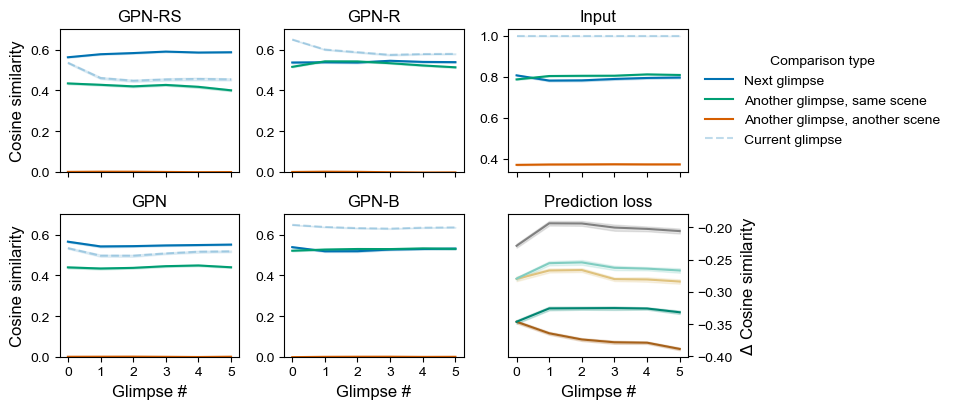

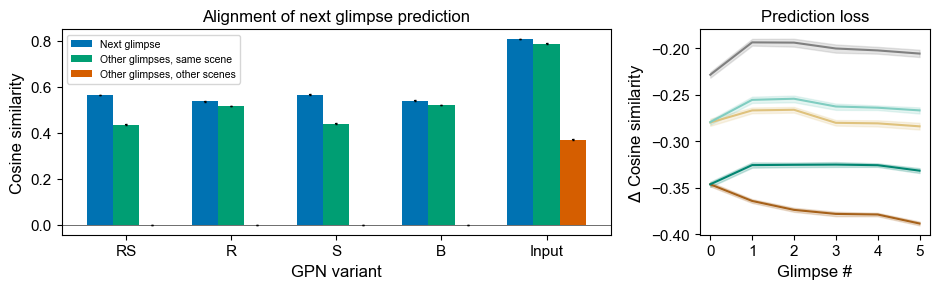

In [4]:
# Figure 1C and Figure S2A

choose_backbone = 'SimCLR'
plot_analyse_beh_quantitative_results(choose_backbone, verbose=True)

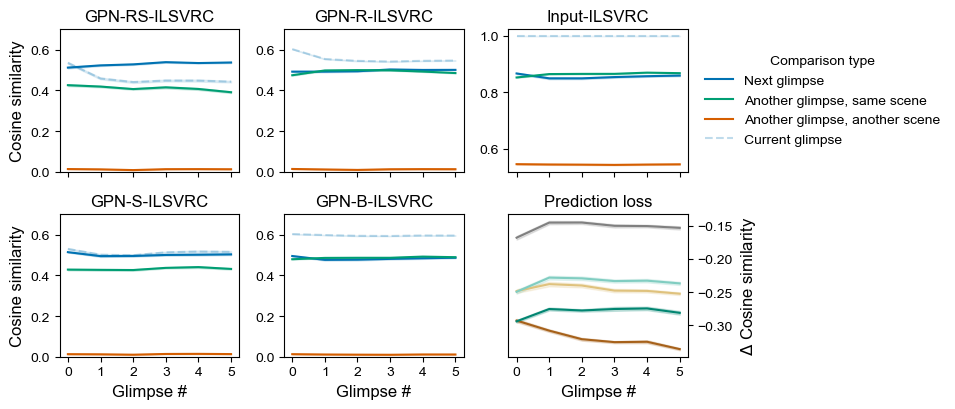

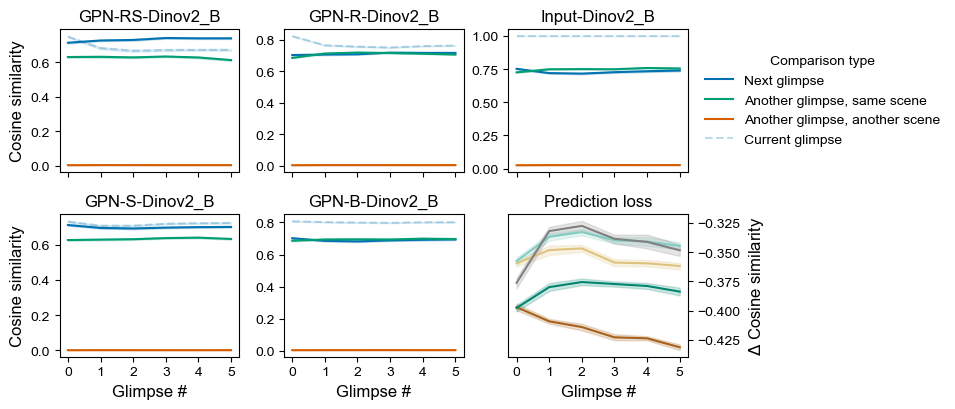

In [5]:
# Figure S2B/C

choose_backbone = 'ILSVRC'
plot_analyse_beh_quantitative_results(choose_backbone)
choose_backbone = 'Dinov2_B'
plot_analyse_beh_quantitative_results(choose_backbone)

### Figure S3A

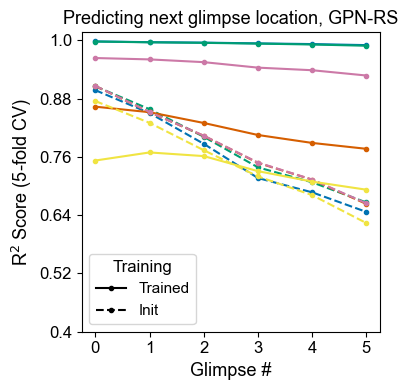

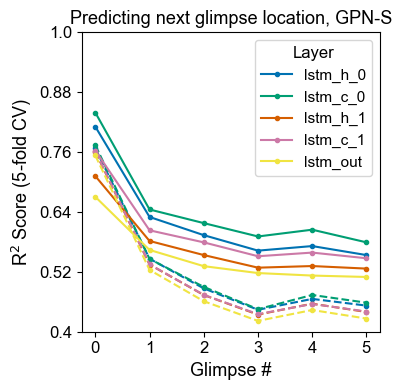

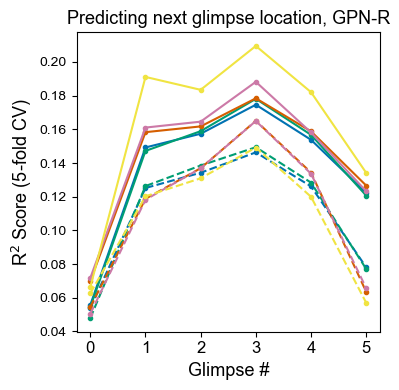

In [6]:
# Plot path integration results

backbone_h = 'SimCLR'  # 'ILSVRC' or 'SimCLR' or 'Dinov2_B'

net_name = gpn_names[f'GPN-RS-{backbone_h}']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_RS = pickle.load(f)
net_name = gpn_names[f'GPN-RS-{backbone_h}-init']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_RS_init = pickle.load(f)
net_name = gpn_names[f'GPN-S-{backbone_h}']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_S = pickle.load(f)
net_name = gpn_names[f'GPN-S-{backbone_h}-init']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_S_init = pickle.load(f)
net_name = gpn_names[f'GPN-R-{backbone_h}']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_R = pickle.load(f)
net_name = gpn_names[f'GPN-R-{backbone_h}-init']
with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
    R2_scores_R_init = pickle.load(f)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# we'll store one line handle per condition (key) for the color legend
color_handles = []
# and make dummy lines for linestyle legend
style_handles = [
    Line2D([0], [0], color='black', linestyle='-', marker='.', label='Trained'),
    Line2D([0], [0], color='black', linestyle='--', marker='.', label='Init')
]
for i, (key, r2_scores) in enumerate(R2_scores_RS.items()):
    color = colors[i % len(colors)]
    # plot both lines with same color
    line_final, = axs.plot(
        list(r2_scores.keys()), list(r2_scores.values()),
        '.-', color=color
    )
    axs.plot(
        list(R2_scores_RS_init[key].keys()), list(R2_scores_RS_init[key].values()),
        '.--', color=color
    )
    color_handles.append(line_final)  # store one representative line per condition
# axis formatting
axs.set_title('Predicting next glimpse location, GPN-RS', fontsize=13) if backbone_h == 'SimCLR' else axs.set_title(f'Predicting next glimpse location, GPN-RS-{backbone_h}', fontsize=13)
axs.set_xlabel('Glimpse #', fontsize=13)
axs.set_ylabel(r'R$^2$ Score (5-fold CV)', fontsize=13)
axs.set_xticks(list(r2_scores.keys()))
axs.set_xticklabels(list(r2_scores.keys()), fontsize=12)
axs.set_yticks(np.round(np.linspace(0.4, 1, 6), 2))
axs.set_yticklabels(np.round(axs.get_yticks(), 2), fontsize=12)
# axs.set_ylim(0.4, 1.1)
# create two separate legends
legend1 = axs.legend(handles=color_handles, labels=R2_scores_RS.keys(),
                     title='Condition', fontsize=11, title_fontsize=12)
legend2 = axs.legend(handles=style_handles, title='Training',
                     fontsize=11, title_fontsize=12)
# add the first legend back manually so both show
# axs.add_artist(legend1)
plt.tight_layout()

fig.savefig(
    f'figures/position_decoding_{backbone_h}_RS.svg',
    format='svg',
    bbox_inches='tight',
    dpi=300.
)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# we'll store one line handle per condition (key) for the color legend
color_handles = []
# and make dummy lines for linestyle legend
style_handles = [
    Line2D([0], [0], color='black', linestyle='-', marker='.', label='Trained'),
    Line2D([0], [0], color='black', linestyle='--', marker='.', label='Init')
]
for i, (key, r2_scores) in enumerate(R2_scores_S.items()):
    color = colors[i % len(colors)]
    # plot both lines with same color
    line_final, = axs.plot(
        list(r2_scores.keys()), list(r2_scores.values()),
        '.-', color=color
    )
    axs.plot(
        list(R2_scores_S_init[key].keys()), list(R2_scores_S_init[key].values()),
        '.--', color=color
    )
    color_handles.append(line_final)  # store one representative line per condition
# axis formatting
axs.set_title('Predicting next glimpse location, GPN-S', fontsize=13) if backbone_h == 'SimCLR' else axs.set_title(f'Predicting next glimpse location, GPN-S-{backbone_h}', fontsize=13)
axs.set_xlabel('Glimpse #', fontsize=13)
axs.set_ylabel(r'R$^2$ Score (5-fold CV)', fontsize=13)
axs.set_xticks(list(r2_scores.keys()))
axs.set_xticklabels(list(r2_scores.keys()), fontsize=12)
axs.set_yticks(np.round(np.linspace(0.4, 1, 6), 2))
axs.set_yticklabels(np.round(axs.get_yticks(), 2), fontsize=12)
# axs.set_ylim(0.4, 1.1)
# create two separate legends
legend1 = axs.legend(handles=color_handles, labels=R2_scores_S.keys(),
                     title='Layer', fontsize=11, title_fontsize=12)
# legend2 = axs.legend(handles=style_handles, title='Training',
#                      fontsize=11, title_fontsize=12)
# add the first legend back manually so both show
# axs.add_artist(legend1)
plt.tight_layout()

fig.savefig(
    f'figures/position_decoding_{backbone_h}_S.svg',
    format='svg',
    bbox_inches='tight',
    dpi=300.
)

fig, axs = plt.subplots(1, 1, figsize=(4, 4))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# we'll store one line handle per condition (key) for the color legend
color_handles = []
# and make dummy lines for linestyle legend
style_handles = [
    Line2D([0], [0], color='black', linestyle='-', marker='.', label='Trained'),
    Line2D([0], [0], color='black', linestyle='--', marker='.', label='Init')
]
for i, (key, r2_scores) in enumerate(R2_scores_R.items()):
    color = colors[i % len(colors)]
    # plot both lines with same color
    line_final, = axs.plot(
        list(r2_scores.keys()), list(r2_scores.values()),
        '.-', color=color
    )
    axs.plot(
        list(R2_scores_R_init[key].keys()), list(R2_scores_R_init[key].values()),
        '.--', color=color
    )
    color_handles.append(line_final)  # store one representative line per condition
# axis formatting
axs.set_title('Predicting next glimpse location, GPN-R', fontsize=13) if backbone_h == 'SimCLR' else axs.set_title(f'Predicting next glimpse location, GPN-R-{backbone_h}', fontsize=13)
axs.set_xlabel('Glimpse #', fontsize=13)
axs.set_ylabel(r'R$^2$ Score (5-fold CV)', fontsize=13)
axs.set_xticks(list(r2_scores.keys()))
axs.set_xticklabels(list(r2_scores.keys()), fontsize=12)
plt.tight_layout()

fig.savefig(
    f'figures/position_decoding_{backbone_h}_R.svg',
    format='svg',
    bbox_inches='tight',
    dpi=300.
)

### Figure 2 (Figures S6-S10)

In [7]:
# Figure 2B

with open(f'best_layers_streams_allrois.pkl', 'rb') as f:
        save_data = pickle.load(f) 
best_layer_names_allrois = save_data['best_layer_names_allrois']
net_corr_best_layers_allrois = save_data['net_corr_best_layers_allrois']
net_names_all_allrois = save_data['net_names_all_allrois']
net_layers_compared_all_allrois = save_data['net_layers_compared_all_allrois']
streams_rois = save_data['streams_rois']

max_values_per_roi = {
    'early': 0.13,
    'midventral': 0.14,
    'midlateral': 0.16,
    'midparietal': 0.12,
    'ventral': 0.27,
    'lateral': 0.13,
    'parietal': 0.11
}

data_NSD = load_pickle('rdms/streams_all_neural_rdms_correlation_special515.pkl')

def compute_alignment(rois, verbose=False, metric='regression'):

    # for select_roi in streams_rois:
    for select_roi in rois:

        net_names_all = net_names_all_allrois[select_roi]
        best_layer_names = best_layer_names_allrois[select_roi]
        net_corr_best_layers = net_corr_best_layers_allrois[select_roi].T

        ROI_RDMs = np.vstack([data_NSD[subj][select_roi] for subj in data_NSD])
        noise_ceilings = {select_roi: compute_noise_ceiling(ROI_RDMs, metric=metric)}

        # GPN-R-SimCLR
        gpn_net_name = gpn_names['GPN-R-SimCLR']
        with open(f'rdms/gpn_rdms_{gpn_net_name}.pkl', 'rb') as f:
            rdm_gpn_r = pickle.load(f)

        # select_gpn_layers = list(rdm_gpn_rs.keys())
        # gpn_layer_names = ['glimpse_input', 'input_proj','rec_layer_1h', 'rec_layer_1c', 'rec_layer_2h', 'rec_layer_2c', 'rec_layer_out', 'output_proj', 'prediction','glimpse_seqadd']
        select_gpn_layers = ['rn50_glimpse', 'lstm_h_0', 'lstm_h_1', 'lstm_out', 'glimpse_output', 'RN50_gl_seqadd']
        gpn_layer_names = ['glimpse_input', 'lstm_h0', 'lstm_h1', 'lstm_out', 'prediction', 'glimpse_seqadd']
        gpn_r_corr = compute_gpn_correlations(ROI_RDMs, rdm_gpn_r, select_gpn_layers, n_glimpse=6, measure=metric)

        # All GPN variants maximum correlations
        gpn_net_names = gpn_names.copy()
        gpn_net_names.pop('GPN-R-SimCLR-DG3p')
        gpn_net_names.pop('GPN-R-SimCLR-DG3r')
        gpn_net_names.pop('GPN-R-SimCLR-random')
        gpn_net_names.pop('GPN-RS-ILSVRC-init')
        gpn_net_names.pop('GPN-S-ILSVRC-init')
        gpn_net_names.pop('GPN-RS-SimCLR-init')
        gpn_net_names.pop('GPN-R-SimCLR-init')
        gpn_net_names.pop('GPN-S-SimCLR-init')
        gpn_net_names.pop('GPN-RS-Dinov2_B-init')
        gpn_net_names.pop('GPN-S-Dinov2_B-init')
        best_gpn_corr = {}
        for gpn_net_name in gpn_net_names:
            best_gpn_corr[gpn_net_name] = {}
            with open(f'rdms/gpn_rdms_{gpn_net_names[gpn_net_name]}.pkl', 'rb') as f:
                rdm_data = pickle.load(f)

            select_gpn_layers_h = list(rdm_data.keys())
            if 'semantic_embed' in select_gpn_layers_h:
                select_gpn_layers_h.remove('semantic_embed')
            gpn_h_corr = compute_gpn_correlations(ROI_RDMs, rdm_data, select_gpn_layers_h, n_glimpse=6, measure=metric)

            # because lstm_out is always the best layer
            best_where = gpn_h_corr.mean(axis=0)
            i, j = np.unravel_index(np.nanargmax(best_where), best_where.shape)
            best_gpn_corr[gpn_net_name]['glimpse_number'] = i
            best_gpn_corr[gpn_net_name]['layer_number'] = j
            best_gpn_corr[gpn_net_name]['rdm'] = rdm_data[select_gpn_layers_h[j]][i]
            best_gpn_corr[gpn_net_name]['correlation'] = gpn_h_corr[:,i,j]
            best_gpn_corr[gpn_net_name]['corr_input_max'] = gpn_h_corr[:,gpn_h_corr[:,:,0].mean(axis=0).argmax(),0]

        # Load the RDMs for the SOTA models and get correlations
        network_rdms = {'O':{},'V':{}, 'VL':{}}
        neth_names = [x for x in net_names_all if 'DG3' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['O']['DG3'] = neth_RDM

        neth_names = [x for x in net_names_all if (('rn50' in x) & ('rn50simlcr' not in x) & ('rn50bt' not in x) & ('rn50init' not in x) & ('coco' not in x)) ]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['RN50-ILSVRC'] = neth_RDM
        neth_names = [x for x in net_names_all if 'rn50simclr' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['RN50-SimCLR'] = neth_RDM
        neth_names = [x for x in net_names_all if 'dinov2_vitb14' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['DINOv2-B'] = neth_RDM
        neth_names = [x for x in net_names_all if 'hardcorenas' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['HardCoReNAS'] = neth_RDM
        neth_names = [x for x in net_names_all if 'levit' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['LeViT'] = neth_RDM
        neth_names = [x for x in net_names_all if 'efficientnet' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['EfficientNet'] = neth_RDM
        neth_names = [x for x in net_names_all if 'dino' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['DINO'] = neth_RDM
        neth_names = [x for x in net_names_all if 'ijepa' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['iJEPA'] = neth_RDM
        neth_names = [x for x in net_names_all if 'mae' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['V']['MAE'] = neth_RDM

        neth_names = [x for x in net_names_all if 'clip' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['VL']['CLIP'] = neth_RDM
        neth_names = [x for x in net_names_all if 'siglip' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['VL']['SigLip2'] = neth_RDM
        neth_names = [x for x in net_names_all if 'mpnet' in x]
        neth_corrs = np.array([net_corr_best_layers[net_names_all.index(x)].mean() for x in neth_names])
        neth_name = neth_names[neth_corrs.argmax()]
        neth_layer = best_layer_names[net_names_all.index(neth_name)]
        with open(f'rdms/{neth_name}_test_515_RDMs.pkl', 'rb') as f:
            neth_RDM = pickle.load(f)[neth_layer]
        network_rdms['VL']['BLT_MPNet'] = neth_RDM

        model_corr, model_names = compute_network_correlations(ROI_RDMs, network_rdms, metric=metric)

        # Get unique variance explained as compared to the best GPN model, GPN-R

        if metric == 'regression':

            unique_variance_ROI_GPN_R_SimCLR = []
            unique_variance_ROI_GPN_R_SimCLR_labels = []

            for gpn_models in gpn_net_names:
                if gpn_models != 'GPN-R-SimCLR':
                    data_h, labels_h = variance_partitioning_analysis(
                        neural_rdm=ROI_RDMs,
                        neural_name=select_roi,
                        A_rdm=best_gpn_corr[gpn_models]['rdm'],
                        A_name=gpn_models,
                        B_rdm=best_gpn_corr['GPN-R-SimCLR']['rdm'],
                        B_name='GPN_R_SimCLR',
                        output_data=True
                    )
                    unique_variance_ROI_GPN_R_SimCLR.append(data_h[0])
                    unique_variance_ROI_GPN_R_SimCLR_labels.append(gpn_models)
                else:
                    unique_variance_ROI_GPN_R_SimCLR.append(np.nan)
                    unique_variance_ROI_GPN_R_SimCLR_labels.append(gpn_models)

            for n, models_h in enumerate(model_names):
                data_h, labels_h = variance_partitioning_analysis(
                    neural_rdm=ROI_RDMs,
                    neural_name=select_roi,
                    A_rdm = (network_rdms['O'][models_h] if models_h in network_rdms['O']
                            else network_rdms['V'][models_h] if models_h in network_rdms['V']
                            else network_rdms['VL'][models_h]),
                    A_name=models_h,
                    B_rdm=best_gpn_corr['GPN-R-SimCLR']['rdm'],
                    B_name='GPN_R_SimCLR',
                    output_data=True
                )
                unique_variance_ROI_GPN_R_SimCLR.append(data_h[0])
                unique_variance_ROI_GPN_R_SimCLR_labels.append(models_h)

        # also ready to plot the actual values for the best GPN, best GSN, and the best non-GPN model; paired
        best_gpn_search = np.array([best_gpn_corr[key]['correlation'].mean() for key in best_gpn_corr if 'GSN' not in key])
        best_gpn_name = list(best_gpn_corr.keys())[best_gpn_search.argmax()]
        best_gpn_correlations = best_gpn_corr[best_gpn_name]['correlation']
        best_gsn_search = np.array([best_gpn_corr[key]['correlation'].mean() for key in best_gpn_corr if 'GSN' in key])
        best_gsn_name = list(best_gpn_corr.keys())[best_gsn_search.argmax()]
        best_gsn_correlations = best_gpn_corr[best_gsn_name]['correlation']
        best_model_search = np.array([model_corr.mean(axis=0)[model_names.index(key)] for key in model_names if key not in best_gpn_corr])
        best_model_name = list(model_names)[best_model_search.argmax()]
        best_model_name_correlations = model_corr[:,model_names.index(best_model_name)]

        fig = plt.figure(figsize=(16, 5.5))
        gs = fig.add_gridspec(1, 3)  # 1 row, 3 columns

        ax_first = fig.add_subplot(gs[0, 0:2])

        ax_second = fig.add_subplot(gs[0, 2])

        max_value = max_values_per_roi[select_roi]

        # Plotting GPN-R-SimCLR layer-wise correlations across glimpses
        ax = ax_second

        palette = sns.husl_palette(len(select_gpn_layers),   # number of non-black lines
                                h=0.0,          # start hue (hue will cycle anyway)
                                l=0.65,         # lightness (try .65–.75)
                                s=0.8) 
        ax.set_prop_cycle(cycler('color', palette))
        n_subjects = gpn_r_corr.shape[0]
        # Plot gp network correlations (one curve per layer across 6 glimpse positions)
        for i, layer in enumerate(select_gpn_layers):
            fmt = 'o-' if i < len(select_gpn_layers)-1 else 'o--'
            mean_h, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_r_corr[:, :, i])
            ax.errorbar(np.arange(6), mean_h,
                        yerr=np.stack([err_low, err_high]),
                        fmt=fmt, label=f'{gpn_layer_names[i]}', alpha=1 if (i == 0 or i == len(select_gpn_layers)-3) else 0.3, color='k' if (i == len(select_gpn_layers)-3) else None)
        labels = [f'{i}' for i in range(6)]
        xtick_positions = [i for i, lab in enumerate(labels)]
        xtick_labels = [lab for lab in labels]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, rotation=0, fontsize=17)
        ax.tick_params(axis='y', labelsize=17)
        ax.set_ylabel(r'Alignment (variance explained, $R^2$)', fontsize=17) if metric == 'regression' else ax.set_ylabel(f'Alignment ({metric} correlation)', fontsize=17)
        ax.set_xlabel('Glimpse #', fontsize=17)
        if select_roi == 'ventral':
            ax.set_title(rf"VVC $\times$GPN-R-SimCLR", fontsize=19)
        else:
            ax.set_title(rf"{select_roi} $\times$GPN-R-SimCLR", fontsize=19)
        ax.legend(
            ncol=2,                     # two columns of labels
            frameon=True,               # optional: remove box around legend
            fontsize=10.5,
            loc='lower center'           
        )
        if metric == 'regression':
            ax.set_ylim(-0.002, max_value)

        # Plotting best GPN, best GSN, and other models
        ax = ax_first

        x_count = 0
        labels = []

        gpn_best_corrs = np.array([best_gpn_corr[key]['correlation'] for key in best_gpn_corr]).T
        gpn_best_corrs_input = np.array([best_gpn_corr[key]['corr_input_max'].mean() for key in best_gpn_corr]).T
        means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_best_corrs)
        colors = [color_coding[key] for key in best_gpn_corr]
        for i, (m, el, eh, c) in enumerate(zip(means_keep[:-2], err_low[:-2], err_high[:-2], colors[:-2])):
            ax.errorbar(
                x_count+i , [m],              # single x, single y (as 1-element list)
                yerr=np.array([[el], [eh]]),  # reshape yerr to (2, 1)
                fmt='o',
                mfc=c,
                mec=c,
                ecolor=c
            )
        best_gpn_xindex = x_count+list(best_gpn_corr.keys()).index(best_gpn_name)
        for i in range(3):
            ax.plot(x_count+np.arange(4)+i*4, np.arange(4)*0+gpn_best_corrs_input[4*i], 'k:', alpha=1.)
        labels += list(gpn_net_names.keys())[:-2] + ['']
        x_count += len(means_keep[:-2]) + 1

        for i, (m, el, eh, c) in enumerate(zip(means_keep[-2:], err_low[-2:], err_high[-2:], colors[-2:])):
            ax.errorbar(
                x_count+i , [m],              # single x, single y (as 1-element list)
                yerr=np.array([[el], [eh]]),  # reshape yerr to (2, 1)
                fmt='o',
                mfc=c,
                mec=c,
                ecolor=c
            )
        best_gsn_xindex = 1+list(best_gpn_corr.keys()).index(best_gsn_name)
        ax.plot(x_count+np.arange(2), np.arange(2)*0+gpn_best_corrs_input[4], 'k:', alpha=1.)
        labels += list(gpn_net_names.keys())[-2:] + ['']
        x_count += len(means_keep[-2:]) + 1

        models_choice_plots = [['DINO','iJEPA','MAE'],['CLIP','SigLip2','BLT_MPNet'],['EfficientNet','LeViT','HardCoReNAS'],['RN50-ILSVRC','RN50-SimCLR','DINOv2-B','DG3']]
        for models_choose_plot in models_choice_plots:
            for model in models_choose_plot:
                means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(model_corr[:,model_names.index(model):model_names.index(model)+1])
                if model in network_rdms['V']:
                    color_use = 'r'
                elif model in network_rdms['VL']:
                    color_use = 'b'
                else:
                    color_use = 'y'
                if model in ['DINO','CLIP','DG3']:
                    label='Visuo-linguistic' if model in network_rdms['VL'] else 'Vision' if model in network_rdms['V'] else 'Vision-X'
                else:
                    label=None
                ax.errorbar(
                    x_count , [means_keep[0]],              # single x, single y (as 1-element list)
                    yerr=np.array([[err_low[0]], [err_high[0]]]),  # reshape yerr to (2, 1)
                    fmt='o',
                    mfc=color_use,
                    mec=color_use,
                    ecolor=color_use,
                    label=label
                )
                if model in best_model_name:
                    best_model_xindex = x_count
                labels += [model]
                x_count += 1
            labels += ['']
            x_count += 1

        labels = labels[:-1]

        ax.axhline(model_corr.mean(axis=0).max(), color='r', linestyle='-.', alpha=0.2)
        xtickpositions = [i for i, lab in enumerate(labels) if lab != '']
        ax.set_xticks(xtickpositions)
        ax.set_xticklabels([lab for lab in labels if lab != ''], rotation=45, fontsize=12, rotation_mode='anchor', ha='right')
        ax.tick_params(axis='y', labelsize=17)
        if metric == 'regression':
            ax.set_ylim(-0.002, max_value)
        # ax.set_title(rf"VVC $\times$ best model RDM;  Noise ceiling = {noise_ceilings['Ventral']**2:.2f}")
        if select_roi == 'ventral':
            ax.set_title(rf"VVC $\times$best network RDM; Subj. shared variance (SV) = {noise_ceilings[select_roi]:.2f}", fontsize=19) if metric=='regression' else ax.set_title(rf"VVC $\times$best network RDM; Subj. shared correlation (SC) = {noise_ceilings[select_roi]:.2f}", fontsize=19)
        else:
            ax.set_title(rf"{select_roi} $\times$best network RDM; Subj. shared variance (SV) = {noise_ceilings[select_roi]:.2f}", fontsize=19) if metric=='regression' else ax.set_title(rf"{select_roi} $\times$best network RDM; Subj. shared correlation (SC) = {noise_ceilings[select_roi]:.2f}", fontsize=19)
        ax.legend(
            loc='upper right',
            frameon=True,               # optional: remove box around legend
            fontsize=10.5,
        )
        ax.set_ylabel(r'Alignment (variance explained, $R^2$)', fontsize=17) if metric == 'regression' else ax.set_ylabel(f'Alignment ({metric} correlation)', fontsize=17)

        if metric == 'regression':
            
            # Plotting unique variance explained compared to GPN-R-SimCLR
            ax2 = ax.twinx()

            x_count = 0

            select_uniq_var = unique_variance_ROI_GPN_R_SimCLR[:len(list(gpn_net_names.keys()))]
            select_uniq_var = [uv for uv in select_uniq_var if isinstance(uv, np.ndarray)]
            select_uniq_var = np.array(select_uniq_var).T

            models_choose_plot = list(gpn_net_names.keys())[:-2]
            models_choose_plot.remove('GPN-R-SimCLR')
            means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(select_uniq_var[:len(models_choose_plot)])
            colors = [color_coding[key] for key in models_choose_plot]
            for i, (m, el, eh, c) in enumerate(zip(means_keep, err_low, err_high, colors)):
                ax2.errorbar(
                    x_count+i if i < list(gpn_net_names.keys()).index('GPN-R-SimCLR') else x_count+i+1, 
                    [m],              # single x, single y (as 1-element list)
                    yerr=np.array([[el], [eh]]),          # single error (as 1×1 list)
                    fmt='s',
                    mfc=c,
                    mec='g',
                    mew=2,
                    ecolor=c
                )
            x_count += len(models_choose_plot) + 2

            models_choose_plot = list(gpn_net_names.keys())[-2:]
            means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(select_uniq_var[-2:])
            colors = [color_coding[key] for key in models_choose_plot]
            for i, (m, el, eh, c) in enumerate(zip(means_keep, err_low, err_high, colors)):
                ax2.errorbar(
                    x_count+i, 
                    [m],              # single x, single y (as 1-element list)
                    yerr=np.array([[el], [eh]]),          # single error (as 1×1 list)
                    fmt='s',
                    mfc=c,
                    mec='g',
                    mew=2,
                    ecolor=c
                )
            x_count += len(models_choose_plot) + 1

            select_uniq_var = unique_variance_ROI_GPN_R_SimCLR[len(list(gpn_net_names.keys())):]
            select_uniq_var = np.array(select_uniq_var).T
            select_net_names = unique_variance_ROI_GPN_R_SimCLR_labels[len(list(gpn_net_names.keys())):]
            models_choice_plots = [['DINO','iJEPA','MAE'],['CLIP','SigLip2','BLT_MPNet'],['EfficientNet','LeViT','HardCoReNAS'],['RN50-ILSVRC','RN50-SimCLR','DINOv2-B','DG3']]
            for models_choose_plot in models_choice_plots:
                for model in models_choose_plot:
                    means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(select_uniq_var[:,select_net_names.index(model):select_net_names.index(model)+1])
                    if model in network_rdms['V']:
                        color_use = 'r'
                    elif model in network_rdms['VL']:
                        color_use = 'b'
                    else:
                        color_use = 'y'
                    ax.errorbar(
                        x_count , [means_keep[0]],              # single x, single y (as 1-element list)
                        yerr=np.array([[err_low[0]], [err_high[0]]]),  # reshape yerr to (2, 1)
                        fmt='s',
                        mfc=color_use,
                        mec='g',
                        ecolor=color_use,
                        mew=2
                    )
                    x_count += 1
                x_count += 1

            ax2.axhline(0, color='k', linestyle='-.', alpha=0.2)
            ax2.set_ylim(-0.002, max_value)
            ax2.tick_params(axis='y', labelsize=17, colors='green')
            ax2.spines['right'].set_color('green')
            ax2.set_ylabel(r'Variance explained $\notin$GPN-R-SimCLR', fontsize=17, color='green')

        plt.tight_layout()

        plt.savefig(
            f'figures/best_model_comparison_{select_roi}_{metric}.svg',
            format='svg',
            dpi=300.
        )

        # Statistical tests
        if verbose:

            # Wilcoxon sign-rank test for lstm_out vs glimpse_input for glimpse 0 in GPN-R-SimCLR
            print('Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0:')
            stat, p = scipy.stats.wilcoxon(gpn_r_corr[:, 0, 3], gpn_r_corr[:, 0, 0])
            mean_diff = np.mean(gpn_r_corr[:, 0, 3] - gpn_r_corr[:, 0, 0])
            print(f'{select_roi} GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0: stat={stat}, p={p}, mean diff={mean_diff}')

            # Wilcoxon sign-rank test for correlation of lstm_out with glimpse number for GPN-R-SimCLR
            print('\nWilcoxon sign-rank test for GPN-R-SimCLR lstm_out correlation with glimpse number (0-5):')
            for subj in range(gpn_r_corr.shape[0]):
                corr = scipy.stats.spearmanr(np.arange(6), gpn_r_corr[subj, :, 3]).statistic
                if subj == 0:
                    corrs = np.array([corr])
                else:
                    corrs = np.append(corrs, corr)
            stat, p = scipy.stats.wilcoxon(corrs)
            mean_val = np.mean(corrs)
            print(f'{select_roi} GPN-R-SimCLR lstm_out correlation with glimpse number: stat={stat}, p={p}, mean val={mean_val}')

            # Wilcoxon sign-rank test for lstm_out glimpse 5 vs glimpse_seqadd max across glimpses in GPN-R-SimCLR
            print('\nWilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses:')
            stat, p = scipy.stats.wilcoxon(gpn_r_corr[:, :, 3].max(axis=1), gpn_r_corr[:, :, 5].max(axis=1))
            mean_diff = np.mean(gpn_r_corr[:, :, 3].max(axis=1) - gpn_r_corr[:, :, 5].max(axis=1))
            print(f'{select_roi} GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses: stat={stat}, p={p}, mean diff={mean_diff}')

            # Wilcoxon sign-rank tests for lstm_out glimpse 5 vs prediction glimpse 5 layer
            print('\nWilcoxon sign-rank tests for GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer:')
            stat, p = scipy.stats.wilcoxon(gpn_r_corr[:, 5, 3], gpn_r_corr[:, 5, 4])
            mean_diff = np.mean(gpn_r_corr[:, 5, 3] - gpn_r_corr[:, 5, 4])
            print(f'{select_roi} GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer: stat={stat}, p={p}, mean diff={mean_diff}')

            # Wilcoxon sign-rank tests for the best GPN model correlations vs their best rn50_glimpse correlations
            print('\nWilcoxon sign-rank tests for the best GPN model correlations vs their best rn50_glimpse correlations:')
            p_vals = []
            for gpn_models in gpn_net_names:
                if 'GSN' not in gpn_models:
                    stat, p = scipy.stats.wilcoxon(best_gpn_corr[gpn_models]['correlation'], best_gpn_corr[gpn_models]['corr_input_max'])
                    p_vals.append(p)
                    mean_diff = np.mean(best_gpn_corr[gpn_models]['correlation'] - best_gpn_corr[gpn_models]['corr_input_max'])
                    print(f'{select_roi} {gpn_models} best layer vs glimpse_input: stat={stat}, p={p}, mean diff={mean_diff}')
            # FDR correction
            reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
            print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

            # 2x2xK Friedman + Wilcoxon tests for the best GPN model correlations (excluding GSN models)
            print('')
            best_gpn_corr_h = best_gpn_corr.copy()
            pop_list = [key for key in best_gpn_corr_h if 'GSN' in key]
            for key in pop_list:
                best_gpn_corr_h.pop(key)
            anova_df = build_2x2xK_df_from_best(best_gpn_corr_h, dv_key='correlation')
            back_levels = ['ILSVRC', 'SimCLR', 'DINOv2-b']
            res = friedman_wilcoxon_2x2xK(anova_df, dv_col='Correlation', back_col='Backbone',
                                rec_col='Recurrence', sac_col='Saccade',
                                rec_levels=('Yes','No'), sac_levels=('Yes','No'),
                                back_levels=back_levels, do_grand_omnibus=True)

            print(res)

            # return the avg diff solely due to recurrence and saccade avged across backbones
            rec_diffs = []
            sac_diffs = []
            for back in back_levels:
                rec_yes = anova_df[(anova_df['Recurrence']=='Yes') & (anova_df['Backbone']==back)]['Correlation'].values
                rec_no = anova_df[(anova_df['Recurrence']=='No') & (anova_df['Backbone']==back)]['Correlation'].values
                sac_yes = anova_df[(anova_df['Saccade']=='Yes') & (anova_df['Backbone']==back)]['Correlation'].values
                sac_no = anova_df[(anova_df['Saccade']=='No') & (anova_df['Backbone']==back)]['Correlation'].values
                rec_diffs.append(np.mean(rec_yes - rec_no))
                sac_diffs.append(np.mean(sac_yes - sac_no))
            print(f'\n{select_roi} Avg diff due to recurrence: {np.mean(rec_diffs)}')
            print(f'{select_roi} Avg diff due to saccade: {np.mean(sac_diffs)}')

            # Wilcoxon sign-rank test for all GPNs vs best non-GPN model 
            print('\nWilcoxon sign-rank test for all GPNs vs best non-GPN model:')
            best_non_gpn_model = model_names[model_corr.mean(axis=0).argmax()]
            p_vals = []
            for gpn_models in best_gpn_corr:
                stat, p = scipy.stats.wilcoxon(best_gpn_corr[gpn_models]['correlation'], model_corr[:,model_names.index(best_non_gpn_model)])
                p_vals.append(p)
                mean_diff = np.mean(best_gpn_corr[gpn_models]['correlation'] - model_corr[:,model_names.index(best_non_gpn_model)])
                print(f'{select_roi} {gpn_models} vs {best_non_gpn_model}: stat={stat}, p={p}, mean diff={mean_diff}')
            # FDR correction
            reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
            print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

            # Wilcoxon sign-rank test for all GPNs vs EfficientNet and DINOv2-vitl14 (important for GPN-R-SimCLR results in VVC)
            print('\nWilcoxon sign-rank test for all GPNs vs EfficientNet and DINO:')
            p_vals = []
            for gpn_models in best_gpn_corr:
                if 'GSN' not in gpn_models:
                    for model_name in ['EfficientNet', 'DINO']:
                        stat, p = scipy.stats.wilcoxon(best_gpn_corr[gpn_models]['correlation'], model_corr[:,model_names.index(model_name)], alternative='greater')
                        p_vals.append(p)
                        mean_diff = np.mean(best_gpn_corr[gpn_models]['correlation'] - model_corr[:,model_names.index(model_name)])
                        print(f'{select_roi} {gpn_models} vs {model_name}: stat={stat}, p={p}, mean diff={mean_diff}')
            # FDR correction
            reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
            print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

            # Wilcoxon sign-rank tests for best GPN-R-SimCLR vs best cGSN and best sGSN models
            print('\nWilcoxon sign-rank tests for best GPN-R-SimCLR vs best cGSN and best sGSN models:')
            p_vals = []
            for net_name in ['cGSN-R-SimCLR', 'sGSN-R-SimCLR']:
                if net_name in best_gpn_corr:
                    stat, p = scipy.stats.wilcoxon(best_gpn_corr['GPN-R-SimCLR']['correlation'], best_gpn_corr[net_name]['correlation'])
                    p_vals.append(p)
                    mean_diff = np.mean(best_gpn_corr['GPN-R-SimCLR']['correlation'] - best_gpn_corr[net_name]['correlation'])
                    print(f'{select_roi} GPN-R-SimCLR vs {net_name}: stat={stat}, p={p}, mean diff={mean_diff}')
            # FDR correction
            reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
            print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

            # highest unique variance explained by any model tested as a proportion of that model's total variance explained
            print('\nHighest unique variance explained by any model as a proportion of that model\'s total variance explained:')
            for uv, uv_label in zip(unique_variance_ROI_GPN_R_SimCLR, unique_variance_ROI_GPN_R_SimCLR_labels):
                if isinstance(uv, np.ndarray):
                    if uv_label in best_gpn_corr:
                        total_var = best_gpn_corr[uv_label]['correlation']
                    else:
                        total_var = model_corr[:,model_names.index(uv_label)]
                    prop_unique = uv / total_var
                    mean_prop = np.mean(prop_unique)
                    print(f'{select_roi} {uv_label} unique variance explained proportion: mean={mean_prop}')

            # Wilcoxon sign-rank tests for highest unique variance explained by EfficientNet (important for GPN-R-SimCLR results in VVC)
            print('\nWilcoxon sign-rank test for unique variance explained by EfficientNet:')
            if 'EfficientNet' in unique_variance_ROI_GPN_R_SimCLR_labels:
                idx_sel = unique_variance_ROI_GPN_R_SimCLR_labels.index('EfficientNet')
                stat, p = scipy.stats.wilcoxon(unique_variance_ROI_GPN_R_SimCLR[idx_sel], method='exact')
                mean_val = np.mean(unique_variance_ROI_GPN_R_SimCLR[idx_sel])
                print(f'{select_roi} Unique variance explained by EfficientNet: stat={stat}, p={p}, mean val={mean_val}')

            # Wilcoxon sign-rank tests for unique variance explained by cGSN and sGSN
            print('\nWilcoxon sign-rank tests for unique variance explained by cGSN and sGSN:')
            p_vals = []
            for net_name in ['cGSN-R-SimCLR', 'sGSN-R-SimCLR']:
                idx_sel = unique_variance_ROI_GPN_R_SimCLR_labels.index(net_name)
                stat, p = scipy.stats.wilcoxon(unique_variance_ROI_GPN_R_SimCLR[idx_sel], method='exact')
                p_vals.append(p)
                mean_val = np.mean(unique_variance_ROI_GPN_R_SimCLR[idx_sel])
                print(f'{select_roi} Unique variance explained by {net_name}: stat={stat}, p={p}, mean val={mean_val}')
            # FDR correction
            reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
            print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

            # Wilcoxon sign-rank tests for sGSN vs BLT_MPNet
            print('\nWilcoxon sign-rank test for sGSN vs BLT_MPNet:')
            stat, p = scipy.stats.wilcoxon(best_gpn_corr['sGSN-R-SimCLR']['correlation'], model_corr[:,model_names.index('BLT_MPNet')])
            mean_diff = np.mean(best_gpn_corr['sGSN-R-SimCLR']['correlation'] - model_corr[:,model_names.index('BLT_MPNet')])
            print(f'{select_roi} sGSN-R-SimCLR vs BLT_MPNet: stat={stat}, p={p}, mean diff={mean_diff}')

            # Wilcoxon sign-rank tests for sGSN vs cGSN
            print('\nWilcoxon sign-rank test for sGSN vs cGSN:')
            stat, p = scipy.stats.wilcoxon(best_gpn_corr['sGSN-R-SimCLR']['correlation'], best_gpn_corr['cGSN-R-SimCLR']['correlation'])
            mean_diff = np.mean(best_gpn_corr['sGSN-R-SimCLR']['correlation'] - best_gpn_corr['cGSN-R-SimCLR']['correlation'])
            print(f'{select_roi} sGSN-R-SimCLR vs cGSN-R-SimCLR: stat={stat}, p={p}, mean diff={mean_diff}')

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0:
ventral GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0: stat=0.0, p=0.0078125, mean diff=0.09980946422743421

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out correlation with glimpse number (0-5):
ventral GPN-R-SimCLR lstm_out correlation with glimpse number: stat=0.0, p=0.0078125, mean val=0.9714285714285715

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses:
ventral GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses: stat=0.0, p=0.0078125, mean diff=0.12793243420357753

Wilcoxon sign-rank tests for GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer:
ventral GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer: stat=0.0, p=0.0078125, mean diff=0.04021289069141533

Wilcoxon sign-rank tests for the best GPN model correlations vs their best rn50_glimpse correlations:
ventral GPN-B-ILSVRC best layer vs glimpse_input: stat=0.0, p=0.0078125, 

/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


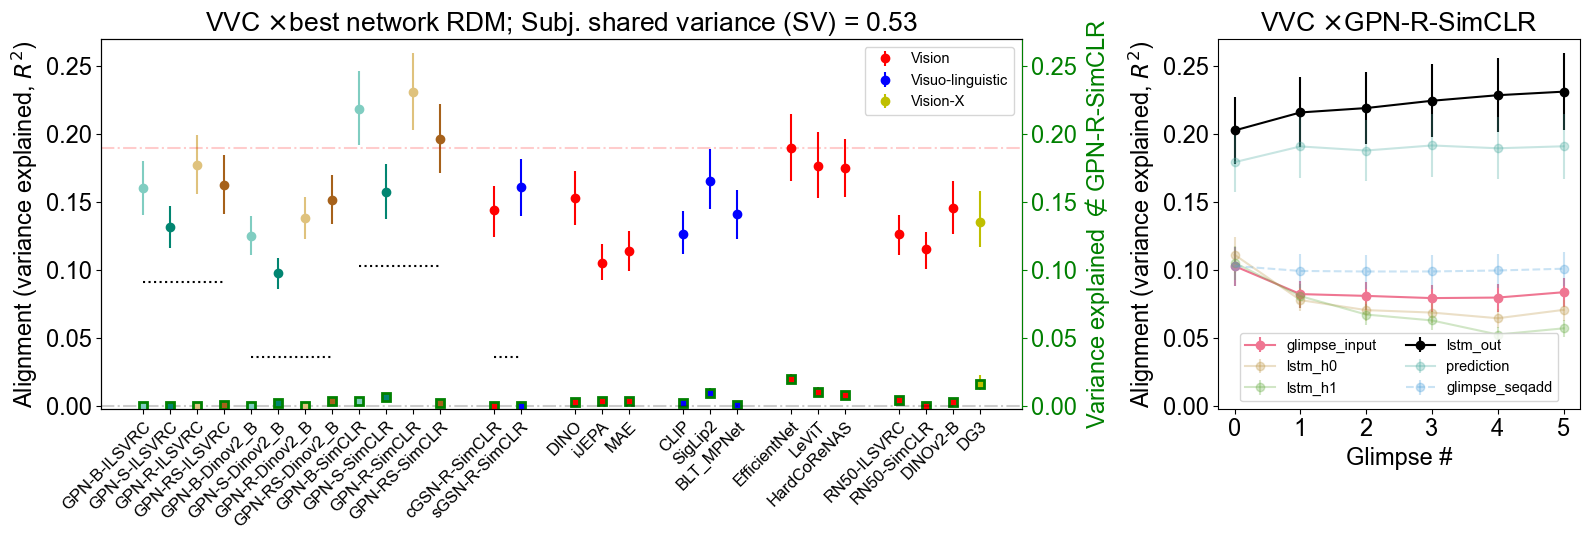

In [8]:
# Figure 2B

compute_alignment(['ventral'], verbose=True)

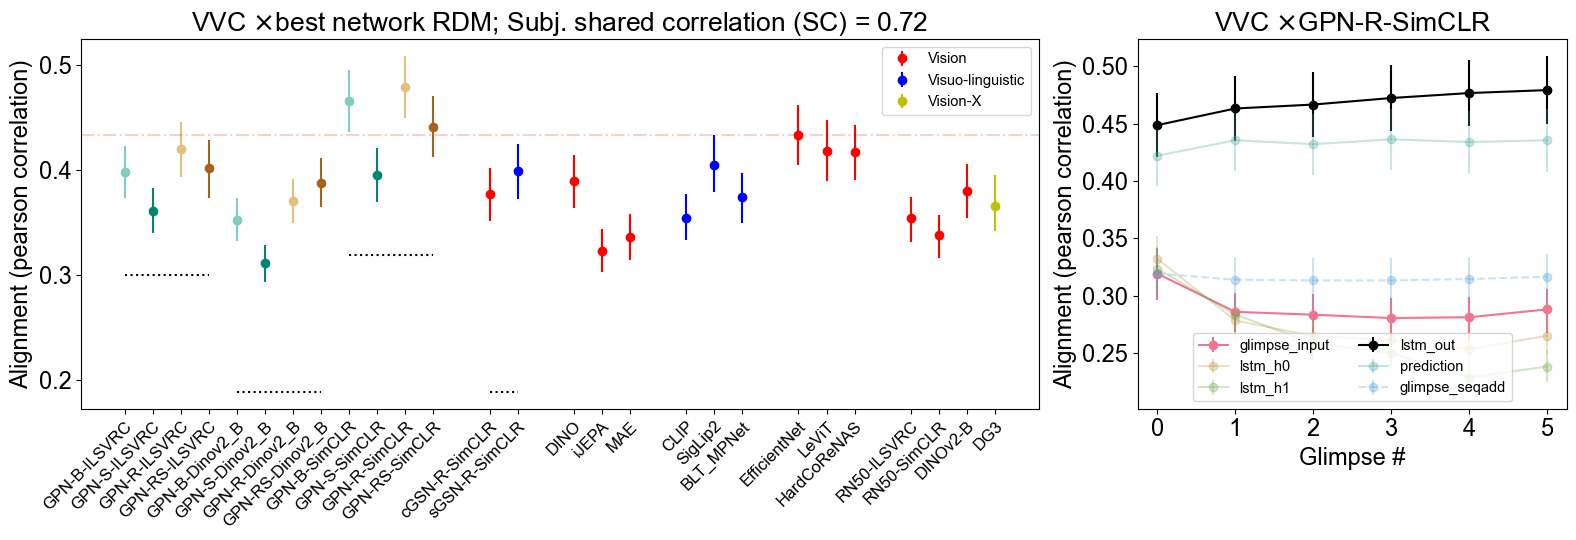

In [9]:
# Figure S10

compute_alignment(['ventral'], metric='pearson')


early Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best rn50_glimpse correlations:
early GPN-R-SimCLR best layer vs glimpse_input: stat=0.0, p=0.0078125, mean diff=0.01201678327939111

early Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best cGSN/sGSN correlations:
early GPN-R-SimCLR vs sGSN-R-SimCLR: stat=0.0, p=0.0078125, mean diff=0.005819893587463626

early Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best non-GPN model correlations:
early GPN-R-SimCLR vs efficientnet_b3: stat=0.0, p=0.0078125, mean diff=-0.059744416014976126

midventral Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best rn50_glimpse correlations:
midventral GPN-R-SimCLR best layer vs glimpse_input: stat=0.0, p=0.0078125, mean diff=0.03492293704827981

midventral Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best cGSN/sGSN correlations:
midventral GPN-R-SimCLR vs sGSN-R-SimCLR: stat=0.0, p=0.0078125, mea

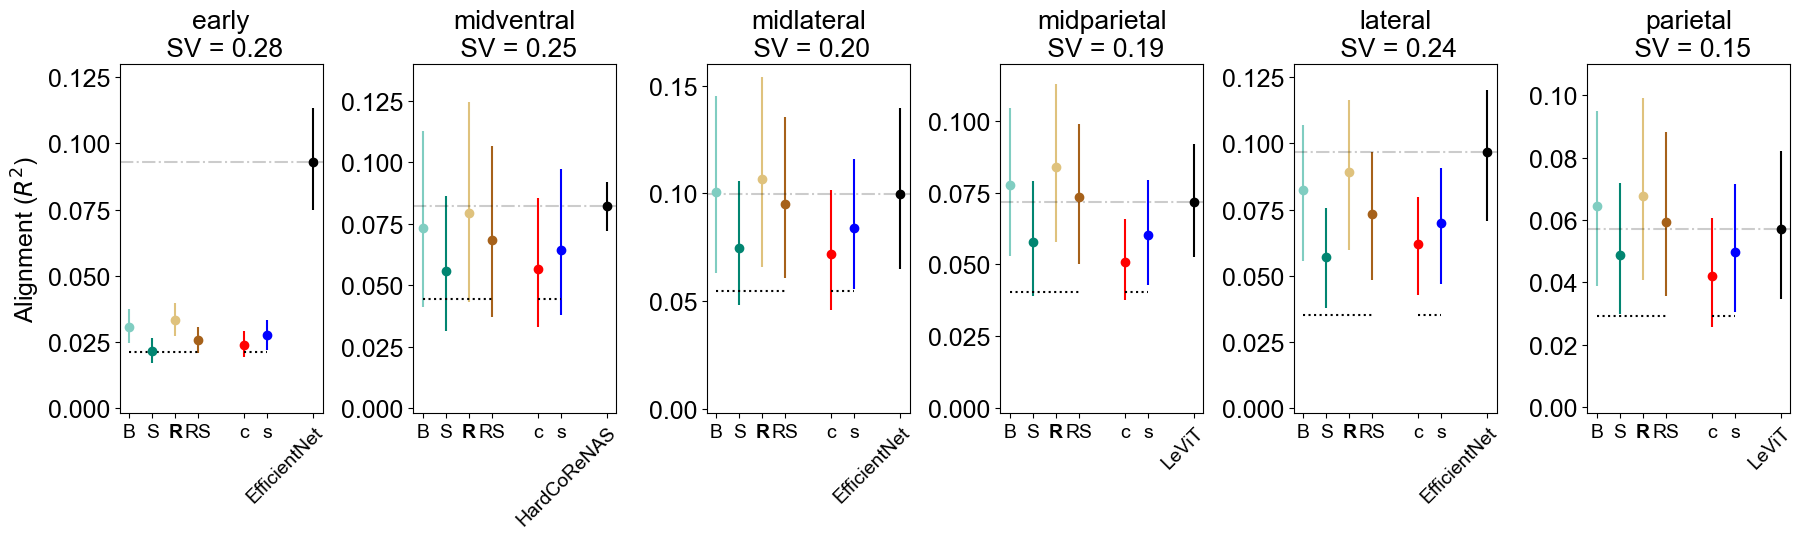

In [10]:
# Figure S6

# Plot the best layers for GPN-R/RS-SimCLR and c/sGSN-R-SimCLR and the best non-gpn network alignment for each roi in streams, in separate subplots in one row

# for select_roi in streams_rois:
streams_rois_h = [names for names in streams_rois if names != 'ventral']

fig, ax_all = plt.subplots(1, len(streams_rois_h), figsize=(18, 5.5))

p_vals_lvsi = []
p_vals_gpnvsgsn = []
p_vals_gpnvsmodel = []
for ni, select_roi in enumerate(streams_rois_h):

    net_names_all = net_names_all_allrois[select_roi]
    best_layer_names = best_layer_names_allrois[select_roi]
    net_corr_best_layers = net_corr_best_layers_allrois[select_roi].T
    net_layers_compared_all = net_layers_compared_all_allrois[select_roi]

    ROI_RDMs = np.vstack([data_NSD[subj][select_roi] for subj in data_NSD])
    noise_ceilings = {select_roi: compute_noise_ceiling(ROI_RDMs)}

    # All GPN variants maximum correlations
    gpn_net_names_h = ['GPN-B-SimCLR','GPN-S-SimCLR','GPN-R-SimCLR','GPN-RS-SimCLR','cGSN-R-SimCLR','sGSN-R-SimCLR']
    best_gpn_corr = {}
    for gpn_net_name in gpn_net_names_h:
        best_gpn_corr[gpn_net_name] = {}
        with open(f'rdms/gpn_rdms_{gpn_names[gpn_net_name]}.pkl', 'rb') as f:
            rdm_data = pickle.load(f)

        select_gpn_layers_h = list(rdm_data.keys())
        if 'semantic_embed' in select_gpn_layers_h:
            select_gpn_layers_h.remove('semantic_embed')
        gpn_h_corr = compute_gpn_correlations(ROI_RDMs, rdm_data, select_gpn_layers_h, n_glimpse=6)

        # because lstm_out is always the best layer
        best_where = gpn_h_corr.mean(axis=0)
        i, j = np.unravel_index(np.nanargmax(best_where), best_where.shape)
        best_gpn_corr[gpn_net_name]['glimpse_number'] = i
        best_gpn_corr[gpn_net_name]['layer_number'] = j
        best_gpn_corr[gpn_net_name]['correlation'] = gpn_h_corr[:,i,j]
        best_gpn_corr[gpn_net_name]['corr_input_max'] = gpn_h_corr[:,gpn_h_corr[:,:,0].mean(axis=0).argmax(),0]

    # Load the correlation for the best model
    best_model_name = net_names_all[net_corr_best_layers.mean(axis=1).argmax()]
    best_model_corrs = net_corr_best_layers[net_names_all.index(best_model_name),:]

    display_name_mapping = {
        'GPN-B-SimCLR': 'B',
        'GPN-S-SimCLR': 'S',
        'GPN-R-SimCLR': 'R',
        'GPN-RS-SimCLR': 'RS',
        'cGSN-R-SimCLR': 'c',
        'sGSN-R-SimCLR': 's',
        'efficientnet_b3': 'EfficientNet',
        'efficientnet_b7': 'EfficientNet',
        'efficientnet_b3_NSD_crop': 'EfficientNet',
        'hardcorenas_f': 'HardCoReNAS',
        'levit_128': 'LeViT',
    }

    ax = ax_all[streams_rois_h.index(select_roi)]

    x_count = 0
    labels = []

    gpn_best_corrs = np.array([best_gpn_corr[key]['correlation'] for key in best_gpn_corr]).T
    gpn_best_corrs_input = np.array([best_gpn_corr[key]['corr_input_max'].mean() for key in best_gpn_corr]).T
    means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_best_corrs)
    colors = [color_coding[key] for key in best_gpn_corr]
    for i, (m, el, eh, c) in enumerate(zip(means_keep[:-2], err_low[:-2], err_high[:-2], colors[:-2])):
        ax.errorbar(
            x_count+i , [m],              # single x, single y (as 1-element list)
            yerr=np.array([[el], [eh]]),  # reshape yerr to (2, 1)
            fmt='o',
            mfc=c,
            mec=c,
            ecolor=c
        )
    ax.plot(np.arange(4), np.arange(4)*0+gpn_best_corrs_input[0], 'k:', alpha=1.)
    labels += list(best_gpn_corr.keys())[:-2] + ['']
    x_count += len(means_keep[:-2]) + 1

    for i, (m, el, eh, c) in enumerate(zip(means_keep[-2:], err_low[-2:], err_high[-2:], colors[-2:])):
        ax.errorbar(
            x_count+i , [m],              # single x, single y (as 1-element list)
            yerr=np.array([[el], [eh]]),  # reshape yerr to (2, 1)
            fmt='o',
            mfc=c,
            mec=c,
            ecolor=c
        )
    ax.plot(x_count+np.arange(2), np.arange(2)*0+gpn_best_corrs_input[0], 'k:', alpha=1.)
    labels += list(best_gpn_corr.keys())[-2:] + ['']
    x_count += len(means_keep[-2:]) + 1

    means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(best_model_corrs[:,None])
    ax.errorbar(
        x_count , [means_keep[0]],              # single x, single y (as 1-element list)
        yerr=np.array([[err_low[0]], [err_high[0]]]),  # reshape yerr to (2, 1)
        fmt='o',
        mfc='k',
        mec='k',
        ecolor='k'
    )
    labels += [best_model_name]

    labels = [display_name_mapping[lab] if lab in display_name_mapping else lab for lab in labels]

    ax.axhline(best_model_corrs.mean(axis=0).max(), color='k', linestyle='-.', alpha=0.2)
    xtickpositions = [i for i, lab in enumerate(labels) if lab != '']
    ax.set_xticks(xtickpositions)
    ax.set_xticklabels([lab for lab in labels if lab != ''], rotation=0, fontsize=14)
    for t in reversed(ax.get_xticklabels()):
        if t.get_text():          # skip '' labels
            t.set_rotation(45)
            t.set_rotation_mode('anchor')
            t.set_ha('right')
            break
    for t in ax.get_xticklabels():
        if t.get_text() in ['R']:
            t.set_fontweight('bold')
    ax.tick_params(axis='y', labelsize=18)
    max_value = max_values_per_roi[select_roi]
    ax.set_ylim(-0.002, max_value)
    # ax.set_title(rf"VVC $\times$ best model RDM;  Noise ceiling = {noise_ceilings['Ventral']**2:.2f}")
    if select_roi == 'ventral':
        ax.set_title(f"VVC\n SV = {noise_ceilings[select_roi]:.2f}", fontsize=19)
    else:
        ax.set_title(f"{select_roi}\n SV = {noise_ceilings[select_roi]:.2f}", fontsize=19)
    if ni == 0:
        ax.set_ylabel(r'Alignment ($R^2$)', fontsize=18)

    if ni == len(streams_rois_h)-1:

        plt.tight_layout()

        plt.savefig(
            f'figures/best_model_comparison_streams.svg',
            format='svg',
            dpi=300.
        )

    # Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best rn50_glimpse correlations
    print(f'\n{select_roi} Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best rn50_glimpse correlations:')
    stat, p = scipy.stats.wilcoxon(best_gpn_corr['GPN-R-SimCLR']['correlation'], best_gpn_corr['GPN-R-SimCLR']['corr_input_max'])
    p_vals_lvsi.append(p)
    mean_diff = np.mean(best_gpn_corr['GPN-R-SimCLR']['correlation'] - best_gpn_corr['GPN-R-SimCLR']['corr_input_max'])
    print(f'{select_roi} GPN-R-SimCLR best layer vs glimpse_input: stat={stat}, p={p}, mean diff={mean_diff}')

    # Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best cGSN/sGSN correlations
    print(f'\n{select_roi} Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best cGSN/sGSN correlations:')
    best_gsn_h = 'cGSN-R-SimCLR' if best_gpn_corr['cGSN-R-SimCLR']['correlation'].mean() > best_gpn_corr['sGSN-R-SimCLR']['correlation'].mean() else 'sGSN-R-SimCLR'    
    stat, p = scipy.stats.wilcoxon(best_gpn_corr['GPN-R-SimCLR']['correlation'], best_gpn_corr[best_gsn_h]['correlation'])
    p_vals_gpnvsgsn.append(p)
    mean_diff = np.mean(best_gpn_corr['GPN-R-SimCLR']['correlation'] - best_gpn_corr[best_gsn_h]['correlation'])
    print(f'{select_roi} GPN-R-SimCLR vs {best_gsn_h}: stat={stat}, p={p}, mean diff={mean_diff}')

    # Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best non-GPN model correlations
    print(f'\n{select_roi} Wilcoxon sign-rank tests for GPN-R-SimCLR best correlation vs their best non-GPN model correlations:')
    stat, p = scipy.stats.wilcoxon(best_gpn_corr['GPN-R-SimCLR']['correlation'], best_model_corrs)
    p_vals_gpnvsmodel.append(p)
    mean_diff = np.mean(best_gpn_corr['GPN-R-SimCLR']['correlation'] - best_model_corrs)
    print(f'{select_roi} GPN-R-SimCLR vs {best_model_name}: stat={stat}, p={p}, mean diff={mean_diff}')

# FDR correction
print('\nFDR correction for p-values across ROIs:')
reject, p_vals_lvsi_corr, _, _ = multipletests(p_vals_lvsi, alpha=0.05, method='fdr_bh')
print('GPN-R-SimCLR vs glimpse_input: Corrected p-values:', p_vals_lvsi_corr, 'Reject null:', reject)
reject, p_vals_gpnvsgsn_corr, _, _ = multipletests(p_vals_gpnvsgsn, alpha=0.05, method='fdr_bh')    
print('GPN-R-SimCLR vs best GSN: Corrected p-values:', p_vals_gpnvsgsn_corr, 'Reject null:', reject)
reject, p_vals_gpnvsmodel_corr, _, _ = multipletests(p_vals_gpnvsmodel, alpha=0.05, method='fdr_bh')    
print('GPN-R-SimCLR vs best non-GPN model: Corrected p-values:', p_vals_gpnvsmodel_corr, 'Reject null:', reject)
    

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0:
midparietal GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0: stat=0.0, p=0.0078125, mean diff=0.035519677459236884

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out correlation with glimpse number (0-5):
midparietal GPN-R-SimCLR lstm_out correlation with glimpse number: stat=0.0, p=0.0078125, mean val=0.7857142857142858

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses:
midparietal GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses: stat=0.0, p=0.0078125, mean diff=0.04381755699766739

Wilcoxon sign-rank tests for GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer:
midparietal GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer: stat=0.0, p=0.0078125, mean diff=0.014766343938580964

Wilcoxon sign-rank tests for the best GPN model correlations vs their best rn50_glimpse correlations:
midparietal GPN-B-ILSVRC best layer vs glimpse_input: s

/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


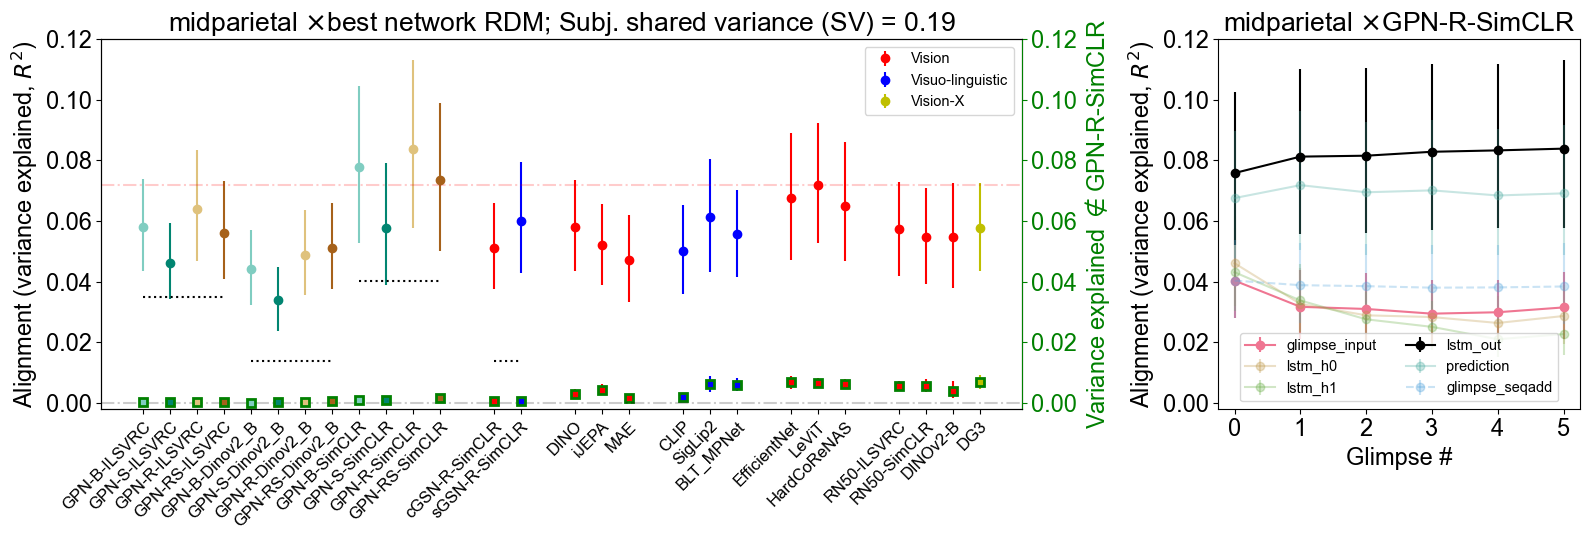

In [11]:
# Figure S7A

compute_alignment(['midparietal'], verbose=True)

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0:
parietal GPN-R-SimCLR lstm_out vs glimpse_input for glimpse 0: stat=0.0, p=0.0078125, mean diff=0.031808535174422614

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out correlation with glimpse number (0-5):
parietal GPN-R-SimCLR lstm_out correlation with glimpse number: stat=0.0, p=0.0078125, mean val=0.9285714285714286

Wilcoxon sign-rank test for GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses:
parietal GPN-R-SimCLR lstm_out vs glimpse_seqadd max values across glimpses: stat=0.0, p=0.0078125, mean diff=0.03824728027416753

Wilcoxon sign-rank tests for GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer:
parietal GPN-R-SimCLR lstm_out vs prediction glimpse 5 layer: stat=0.0, p=0.0078125, mean diff=0.01120677213766054

Wilcoxon sign-rank tests for the best GPN model correlations vs their best rn50_glimpse correlations:
parietal GPN-B-ILSVRC best layer vs glimpse_input: stat=0.0, p=0.007

/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/Users/sushrutthorat/miniconda3/envs/pytorch2/lib/python3.9/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


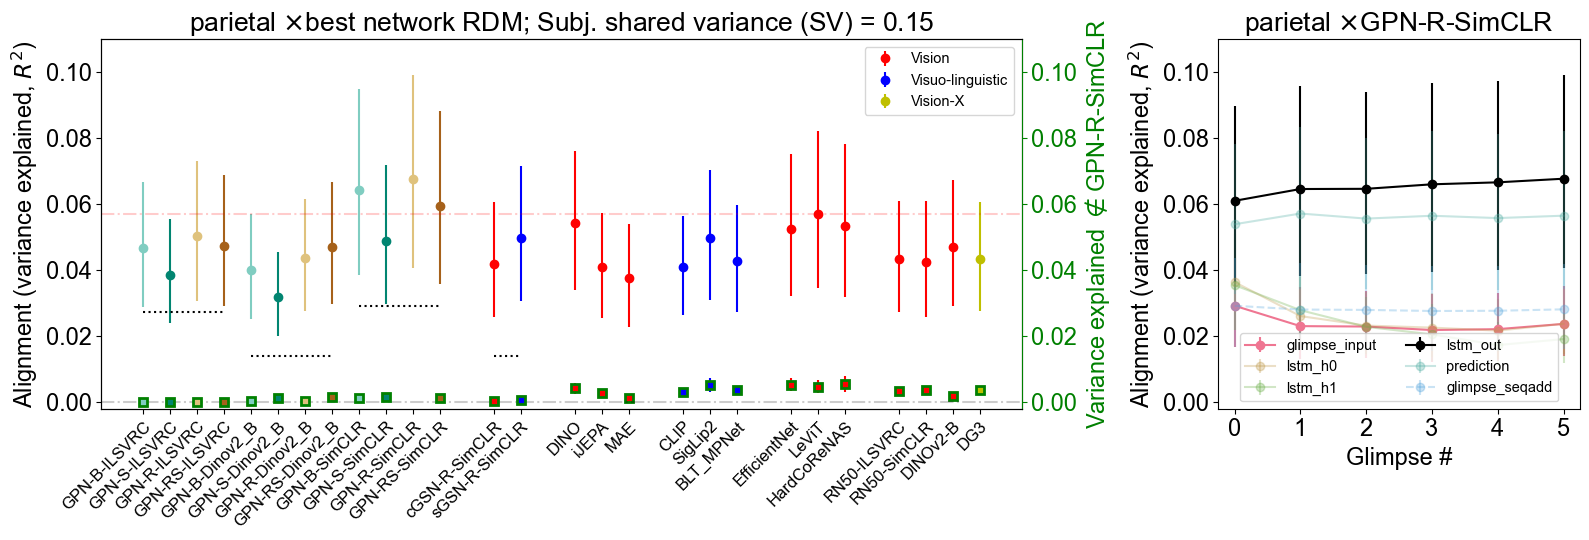

In [12]:
# Figure S7B

compute_alignment(['parietal'], verbose=True)

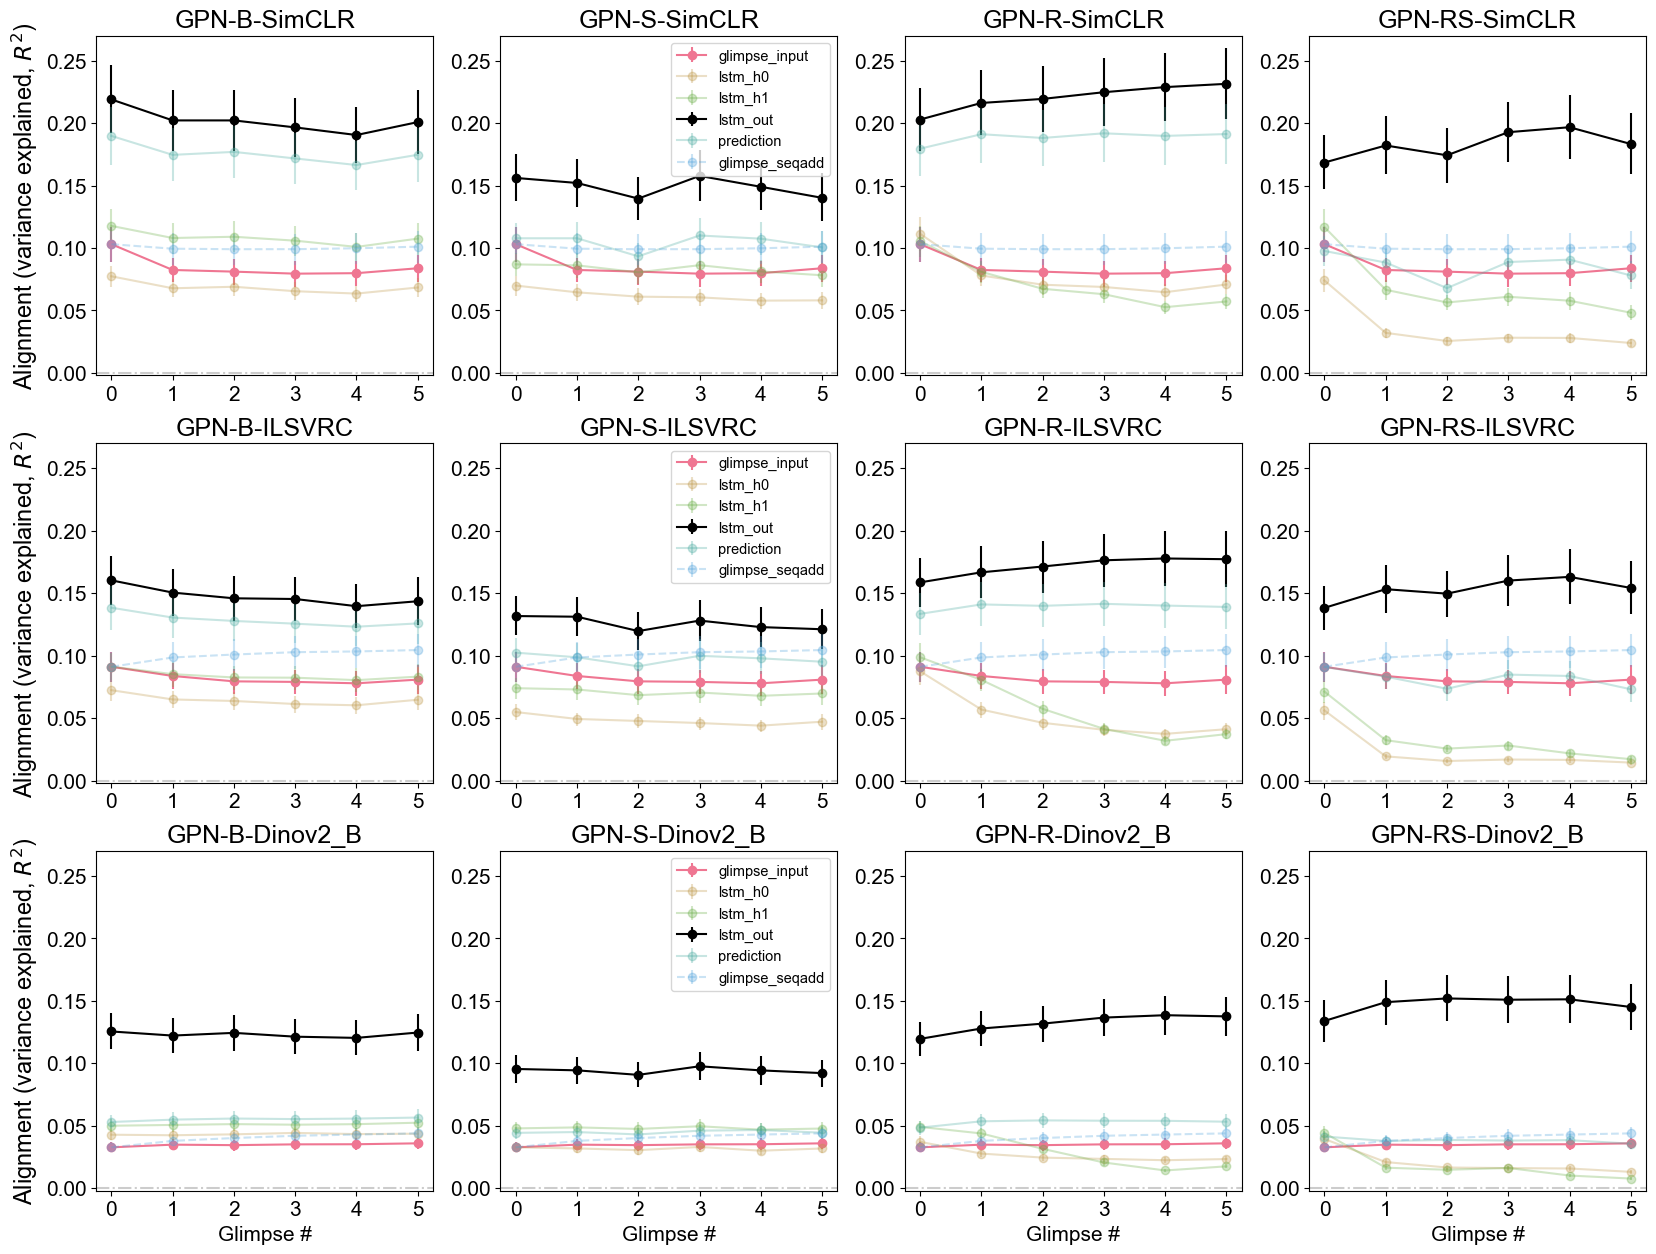

In [13]:
# Figure S8

# Plot GPN alignment across layers and glimpses for ventral, across variants and backbones

select_roi = 'ventral'

net_names_all = net_names_all_allrois[select_roi]
best_layer_names = best_layer_names_allrois[select_roi]
net_corr_best_layers = net_corr_best_layers_allrois[select_roi].T
net_layers_compared_all = net_layers_compared_all_allrois[select_roi]

ROI_RDMs = np.vstack([data_NSD[subj][select_roi] for subj in data_NSD])
noise_ceilings = {select_roi: compute_noise_ceiling(ROI_RDMs, metric='regression')}

select_gpn_layers = ['rn50_glimpse', 'lstm_h_0', 'lstm_h_1', 'lstm_out', 'glimpse_output', 'RN50_gl_seqadd']
gpn_layer_names = ['glimpse_input', 'lstm_h0', 'lstm_h1', 'lstm_out', 'prediction', 'glimpse_seqadd']

gpn_backbones = ['SimCLR', 'ILSVRC', 'Dinov2_B']
gpns_to_plot = ['GPN-B','GPN-S','GPN-R','GPN-RS']

fig, ax_all = plt.subplots(len(gpn_backbones), len(gpns_to_plot), figsize=(20, 15))

for bi, gpn_backbone in enumerate(gpn_backbones):

    gpn_names_h = [ f'{gpn}-{gpn_backbone}' for gpn in gpns_to_plot]

    for gpn_name in gpn_names_h:

        gpn_net_name = gpn_names[gpn_name]
        with open(f'rdms/gpn_rdms_{gpn_net_name}.pkl', 'rb') as f:
            rdm_gpn_h = pickle.load(f)

        gpn_h_corr = compute_gpn_correlations(ROI_RDMs, rdm_gpn_h, select_gpn_layers, n_glimpse=6, measure='regression')

        ax = ax_all[bi,gpn_names_h.index(gpn_name)]
        palette = sns.husl_palette(len(select_gpn_layers),   # number of non-black lines
                                h=0.0,          # start hue (hue will cycle anyway)
                                l=0.65,         # lightness (try .65–.75)
                                s=0.8) 
        ax.set_prop_cycle(cycler('color', palette))
        n_subjects = gpn_h_corr.shape[0]
        # Plot gp network correlations (one curve per layer across 6 glimpse positions)
        for i, layer in enumerate(select_gpn_layers):
            fmt = 'o-' if i < len(select_gpn_layers)-1 else 'o--'
            mean_h, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_h_corr[:, :, i])
            ax.errorbar(np.arange(6), mean_h,
                        yerr=np.stack([err_low, err_high]),
                        fmt=fmt, label=f'{gpn_layer_names[i]}', alpha=1 if (i == 0 or i == len(select_gpn_layers)-3) else 0.3, color='k' if (i == len(select_gpn_layers)-3) else None)
        ax.set_xticks(np.arange(6))
        ax.set_xticklabels([str(i) for i in range(6)], fontsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.set_ylim(-0.002, max_values_per_roi[select_roi])
        ax.set_title(f'{gpn_name}', fontsize=18)
        if 'GPN-B' in gpn_name:
            ax.set_ylabel(r'Alignment (variance explained, $R^2$)', fontsize=17)
        if bi == len(gpn_backbones)-1:
            ax.set_xlabel('Glimpse #', fontsize=15)
        if 'GPN-S' in gpn_name:
            ax.legend(
                loc='upper right',
                frameon=True,               # optional: remove box around legend
                fontsize=10.5,
            )
        ax.axhline(0, color='k', linestyle='-.', alpha=0.2)

plt.savefig(
    f'figures/gpn_layers_glimpses_backbones_ventral_regression.svg',
    format='svg',
    dpi=300.
)


ventral Wilcoxon sign-rank tests for su pairwise comparisons among GPN-R-SimCLR fixation variations:
ventral GPN-R-SimCLR vs GPN-R-SimCLR-DG3p: stat=0.0, p=0.0078125, mean diff=0.013482161393610664
ventral GPN-R-SimCLR vs GPN-R-SimCLR-DG3r: stat=0.0, p=0.0078125, mean diff=0.0566723409425436
ventral GPN-R-SimCLR vs GPN-R-SimCLR-random: stat=0.0, p=0.0078125, mean diff=0.08831222703517326
ventral GPN-R-SimCLR-DG3p vs GPN-R-SimCLR-DG3r: stat=0.0, p=0.0078125, mean diff=0.043190179548932936
ventral GPN-R-SimCLR-DG3p vs GPN-R-SimCLR-random: stat=0.0, p=0.0078125, mean diff=0.0748300656415626
ventral GPN-R-SimCLR-DG3r vs GPN-R-SimCLR-random: stat=0.0, p=0.0078125, mean diff=0.03163988609262966
Corrected p-values: [0.0078125 0.0078125 0.0078125 0.0078125 0.0078125 0.0078125] Reject null: [ True  True  True  True  True  True]

ventral Wilcoxon sign-rank tests for GPN-R-SimCLR-random vs input_glimpse:
ventral GPN-R-SimCLR-random vs glimpse_input: stat=0.0, p=0.0078125, mean diff=0.04008139336

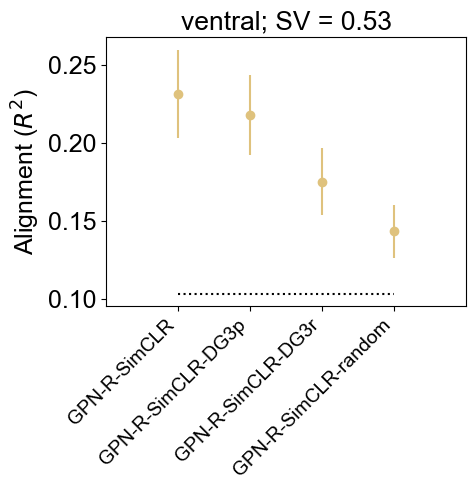

In [14]:
# Figure S9

# Plot GPN-R-SimCLR variations based on the fixations - normal (dg3), dg3-permuted, dg3-swap, and random

select_roi = 'ventral'
backbone_h = 'SimCLR'

net_names_all = net_names_all_allrois[select_roi]
best_layer_names = best_layer_names_allrois[select_roi]
net_corr_best_layers = net_corr_best_layers_allrois[select_roi].T
net_layers_compared_all = net_layers_compared_all_allrois[select_roi]

ROI_RDMs = np.vstack([data_NSD[subj][select_roi] for subj in data_NSD])
noise_ceilings = {select_roi: compute_noise_ceiling(ROI_RDMs)}

# All GPN variants maximum correlations
gpn_net_names_h = [f'GPN-R-{backbone_h}',f'GPN-R-{backbone_h}-DG3p',f'GPN-R-{backbone_h}-DG3r',f'GPN-R-{backbone_h}-random']
best_gpn_corr = {}
for gpn_net_name in gpn_net_names_h:
    best_gpn_corr[gpn_net_name] = {}
    with open(f'rdms/gpn_rdms_{gpn_names[gpn_net_name]}.pkl', 'rb') as f:
        rdm_data = pickle.load(f)

    select_gpn_layers_h = list(rdm_data.keys())
    if 'semantic_embed' in select_gpn_layers_h:
        select_gpn_layers_h.remove('semantic_embed')
    gpn_h_corr = compute_gpn_correlations(ROI_RDMs, rdm_data, select_gpn_layers_h, n_glimpse=6)

    # because lstm_out is always the best layer
    best_where = gpn_h_corr.mean(axis=0)
    i, j = np.unravel_index(np.nanargmax(best_where), best_where.shape)
    best_gpn_corr[gpn_net_name]['glimpse_number'] = i
    best_gpn_corr[gpn_net_name]['layer_number'] = j
    best_gpn_corr[gpn_net_name]['correlation'] = gpn_h_corr[:,i,j]
    best_gpn_corr[gpn_net_name]['correlation_g0'] = gpn_h_corr[:,0,j]
    best_gpn_corr[gpn_net_name]['corr_input_max'] = gpn_h_corr[:,gpn_h_corr[:,:,0].mean(axis=0).argmax(),0]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x_count = 0
labels = list(best_gpn_corr.keys())
gpn_best_corrs = np.array([best_gpn_corr[key]['correlation'] for key in best_gpn_corr]).T
gpn_best_corrs_input = np.array([best_gpn_corr[key]['corr_input_max'].mean() for key in best_gpn_corr]).T
means_keep, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_best_corrs)
colors = [color_coding[key] for key in best_gpn_corr]
for i, (m, el, eh, c) in enumerate(zip(means_keep, err_low, err_high, colors)):
    ax.errorbar(
        x_count+i , [m],              # single x, single y (as 1-element list)
        yerr=np.array([[el], [eh]]),  # reshape yerr to (2, 1)
        fmt='o',
        mfc=c,
        mec=c,
        ecolor=c
    )
ax.plot(np.arange(len(means_keep)), gpn_best_corrs_input, 'k:', alpha=1.)
# ax.axhline(0, color='k', linestyle='-.', alpha=0.2)
# ax.set_ylim(, max_values_per_roi[select_roi]+1)
ax.set_title(f"{select_roi}; SV = {noise_ceilings[select_roi]:.2f}", fontsize=19)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=14)
ax.set_xlim(-1, len(labels))
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel(r'Alignment ($R^2$)', fontsize=18)
plt.tight_layout()

plt.savefig(
    f'figures/gpn_r_fixation_variations_{select_roi}.svg',
    format='svg',
    dpi=300.
)

# stats

# Wilcoxon sign-rank tests for all pairwise comparisons among GPN-R-SimCLR fixation variations
print(f'\n{select_roi} Wilcoxon sign-rank tests for su pairwise comparisons among GPN-R-SimCLR fixation variations:')
p_vals = []
gpn_variations = list(best_gpn_corr.keys())
for i in range(len(gpn_variations)):
    for j in range(i+1, len(gpn_variations)):
        stat, p = scipy.stats.wilcoxon(best_gpn_corr[gpn_variations[i]]['correlation'], best_gpn_corr[gpn_variations[j]]['correlation'])
        p_vals.append(p)
        mean_diff = np.mean(best_gpn_corr[gpn_variations[i]]['correlation'] - best_gpn_corr[gpn_variations[j]]['correlation'])
        print(f'{select_roi} {gpn_variations[i]} vs {gpn_variations[j]}: stat={stat}, p={p}, mean diff={mean_diff}')
# FDR correction
reject, p_vals_corr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
print('Corrected p-values:', p_vals_corr, 'Reject null:', reject)

# Wilcoxon sign-rank tests for GPN-R-SimCLR-random vs input_glimpse
print(f'\n{select_roi} Wilcoxon sign-rank tests for GPN-R-SimCLR-random vs input_glimpse:')
stat, p = scipy.stats.wilcoxon(best_gpn_corr['GPN-R-SimCLR-random']['correlation'], best_gpn_corr['GPN-R-SimCLR-random']['corr_input_max'])
mean_diff = np.mean(best_gpn_corr['GPN-R-SimCLR-random']['correlation'] - best_gpn_corr['GPN-R-SimCLR-random']['corr_input_max'])
print(f'{select_roi} GPN-R-SimCLR-random vs glimpse_input: stat={stat}, p={p}, mean diff={mean_diff}')

# Print glimpse numbers for each GPN-R-SimCLR variation
print(f'\n{select_roi} max-alignment Glimpse numbers for each GPN-R-SimCLR variation:')
for gpn_variation in best_gpn_corr:
    print(f'{gpn_variation}: glimpse number = {best_gpn_corr[gpn_variation]["glimpse_number"]}')

### Table S5

In [ ]:
roi_choose = 'ventral'

print(f'\nBest layers for GPNs in {roi_choose} ROI:\n')

gpn_net_names = gpn_names.copy()
gpn_net_names.pop('GPN-R-SimCLR-DG3p')
gpn_net_names.pop('GPN-R-SimCLR-DG3r')
gpn_net_names.pop('GPN-R-SimCLR-random')
gpn_net_names.pop('GPN-RS-ILSVRC-init')
gpn_net_names.pop('GPN-S-ILSVRC-init')
gpn_net_names.pop('GPN-RS-SimCLR-init')
gpn_net_names.pop('GPN-R-SimCLR-init')
gpn_net_names.pop('GPN-S-SimCLR-init')
gpn_net_names.pop('GPN-RS-Dinov2_B-init')
gpn_net_names.pop('GPN-S-Dinov2_B-init')
best_gpn_corr = {}
ROI_RDMs = np.vstack([data_NSD[subj][roi_choose] for subj in data_NSD])
for gpn_net_name in gpn_net_names:
    best_gpn_corr[gpn_net_name] = {}
    with open(f'rdms/gpn_rdms_{gpn_net_names[gpn_net_name]}.pkl', 'rb') as f:
        rdm_data = pickle.load(f)

    select_gpn_layers_h = list(rdm_data.keys())
    if 'semantic_embed' in select_gpn_layers_h:
        select_gpn_layers_h.remove('semantic_embed')
    gpn_h_corr = compute_gpn_correlations(ROI_RDMs, rdm_data, select_gpn_layers_h, n_glimpse=6)

    # because lstm_out is always the best layer
    best_where = gpn_h_corr.mean(axis=0)
    i, j = np.unravel_index(np.nanargmax(best_where), best_where.shape)
    best_gpn_corr[gpn_net_name]['glimpse_number'] = i
    best_gpn_corr[gpn_net_name]['layer_number'] = j
    best_gpn_corr[gpn_net_name]['layer_name'] = select_gpn_layers_h[j]
    best_gpn_corr[gpn_net_name]['rdm'] = rdm_data[select_gpn_layers_h[j]][i]
    best_gpn_corr[gpn_net_name]['correlation'] = gpn_h_corr[:,i,j]
    best_gpn_corr[gpn_net_name]['corr_input_max'] = gpn_h_corr[:,gpn_h_corr[:,:,0].mean(axis=0).argmax(),0]

for gname in best_gpn_corr:
    print(gname,best_gpn_corr[gname]['glimpse_number'], best_gpn_corr[gname]['layer_name'],best_gpn_corr[gname]['correlation'].mean())

print(f'\nBest layers for alternative networks in {roi_choose} ROI:\n')

indices_list = sorted(range(len(net_names_all_allrois[roi_choose])), key=lambda i: net_names_all_allrois[roi_choose][i])
for i in indices_list:
    print(net_names_all_allrois[roi_choose][i], best_layer_names_allrois[roi_choose][i], net_layers_compared_all_allrois[roi_choose][i], net_corr_best_layers_allrois[roi_choose][:,i].mean())


Best layers for GPNs in ventral ROI:
"
GPN-B-ILSVRC 0 lstm_out 0.16032241169237807
GPN-S-ILSVRC 0 lstm_out 0.13174142251415993
GPN-R-ILSVRC 4 lstm_out 0.1778329985469358
GPN-RS-ILSVRC 4 lstm_out 0.16309658145279066
GPN-B-Dinov2_B 0 lstm_out 0.12550919463747023
GPN-S-Dinov2_B 3 lstm_out 0.09763736260804684
GPN-R-Dinov2_B 4 lstm_out 0.13854035653039373
GPN-RS-Dinov2_B 2 lstm_out 0.1519718608686155
GPN-B-SimCLR 0 lstm_out 0.21897435639829035
GPN-S-SimCLR 3 lstm_out 0.15776195200886944
GPN-R-SimCLR 5 lstm_out 0.23147525764941074
GPN-RS-SimCLR 4 lstm_out 0.19673081472277487
cGSN-R-SimCLR 0 joint_proj 0.14403664659212878
sGSN-R-SimCLR 0 joint_proj 0.1611040040604176

Best layers for alternative networks in ventral ROI:
"
DG3 features.features.1.features.denseblock4.denselayer3.norm1 986 0.11248808003821206
DG3_NSD_crop features.features.1.features.denseblock3.denselayer28.norm2 986 0.13549810812249538
alexnet classifier.1 23 0.13790681606993915
alexnet_NSD_crop classifier.1 23 0.09667971318